In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np
import os 

%matplotlib inline

In [56]:
def to_onehot(x, n, device=None):
    if isinstance(x, np.ndarray):
        x = torch.Tensor(x).to(torch.long)
    one_hot = torch.zeros((x.shape[0], n))
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot

In [ ]:
def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [57]:
def plot_mnist(images, shape, show=True, save_to=None):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    if save_to is not None:
        plt.savefig(save_to)
        
    if show:
        plt.show()
    else:
        plt.close()

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
root_folder = 'FC_AAE_C_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [6]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cpu


In [8]:
data, label = next(iter(train_loader))

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [34]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)

Dec = FullyConnected([prior_size, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [35]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [36]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [43]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        
        latent = Enc(data)
        
        reconstructed = Dec(latent).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [53]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            latent = Enc(data)
            reconstructed = Dec(latent).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data)).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.5716, AE: 0.2408, D: 0.8228
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 0.5824, AE: 0.2336, D: 0.7298
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.6257, AE: 0.2429, D: 0.8455


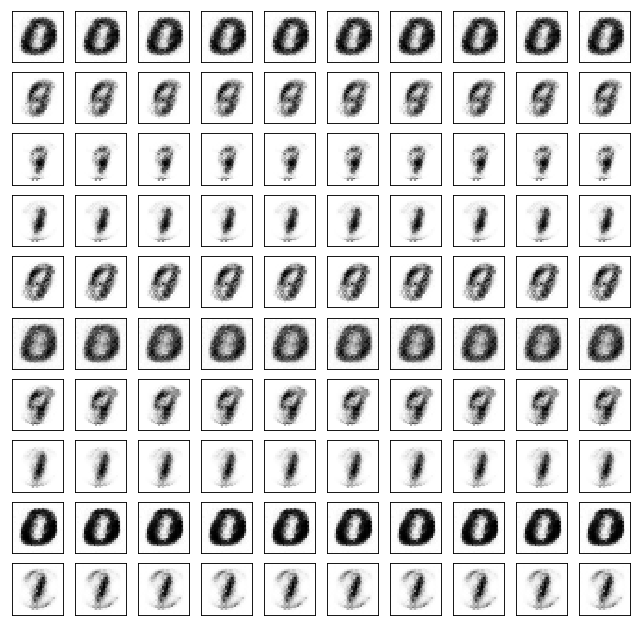

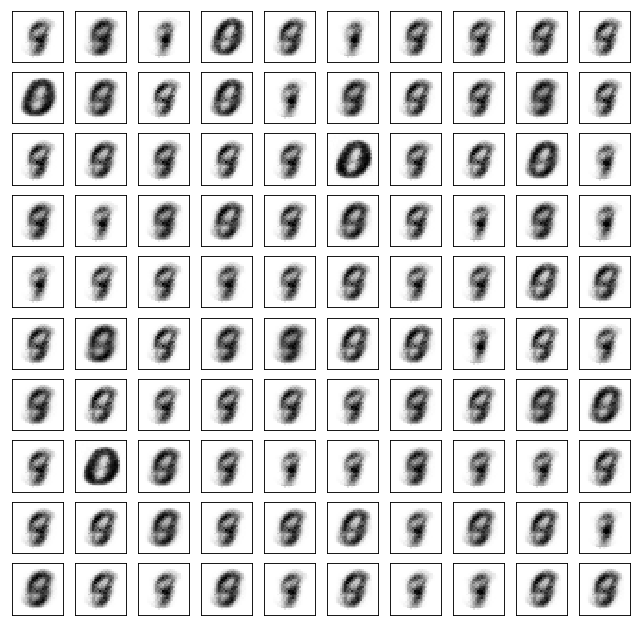

Test losses. E: 0.5987, AE: 0.2478, D: 0.8386
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.6289, AE: 0.2433, D: 0.8550
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.5505, AE: 0.2344, D: 0.7471
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.5435, AE: 0.2261, D: 0.7161


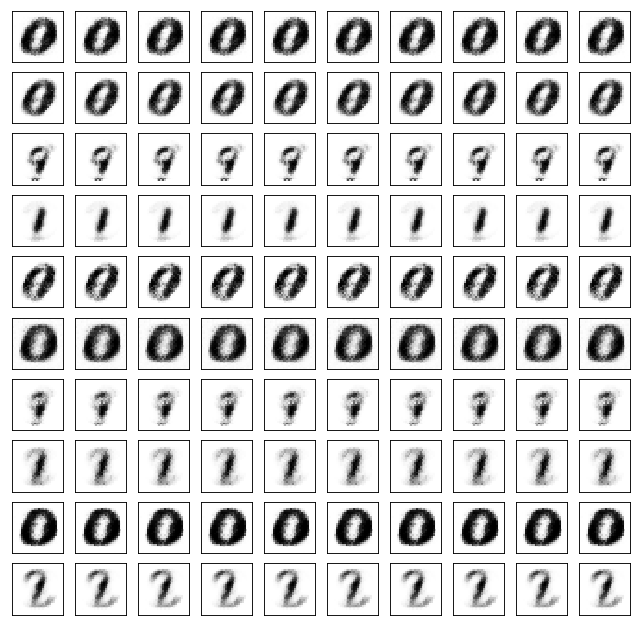

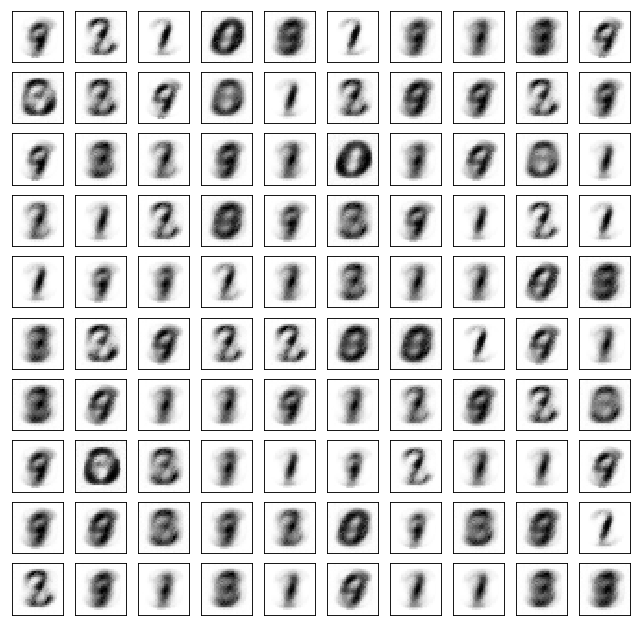

Test losses. E: 0.5321, AE: 0.2277, D: 0.7127
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.5395, AE: 0.2332, D: 0.7123
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.7269, AE: 0.2231, D: 0.8137
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5823, AE: 0.2252, D: 0.7119


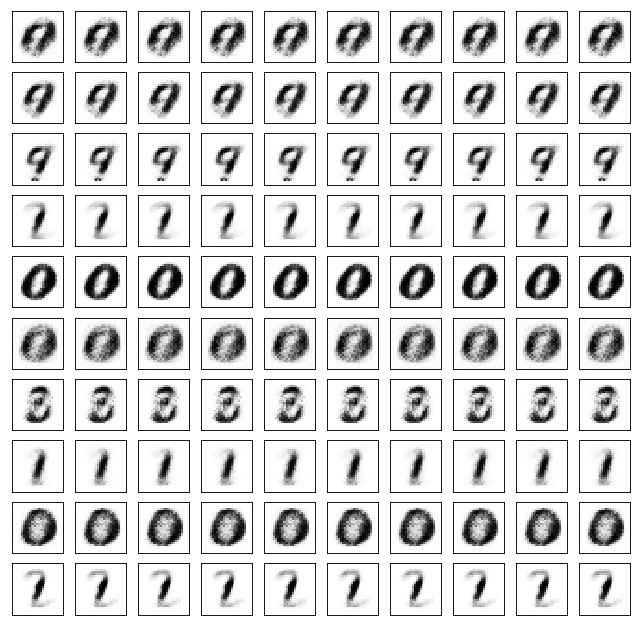

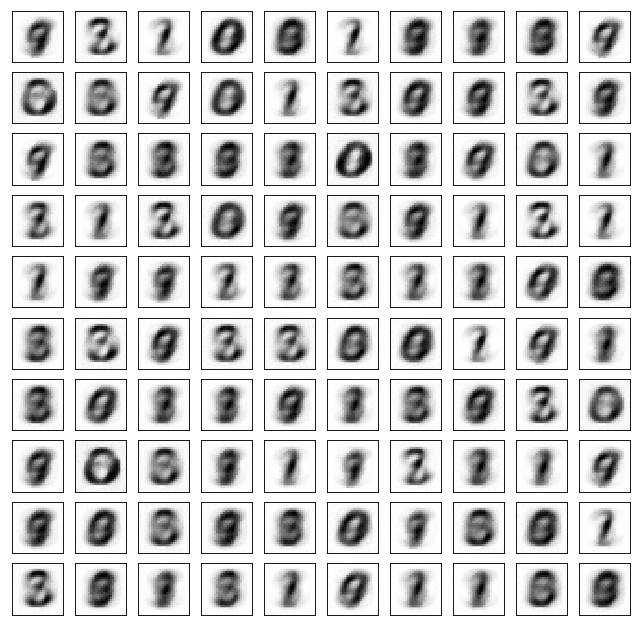

Test losses. E: 0.5783, AE: 0.2257, D: 0.7103
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5791, AE: 0.2226, D: 0.7169
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.6037, AE: 0.2230, D: 0.7151
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.7130, AE: 0.2626, D: 0.8015


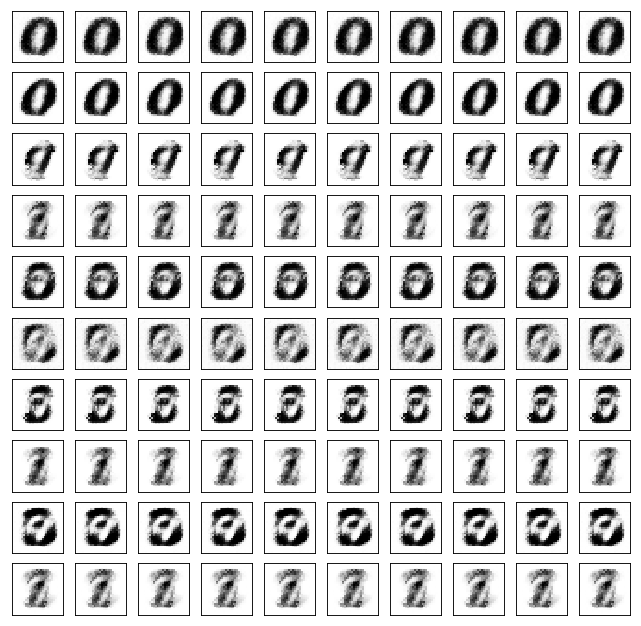

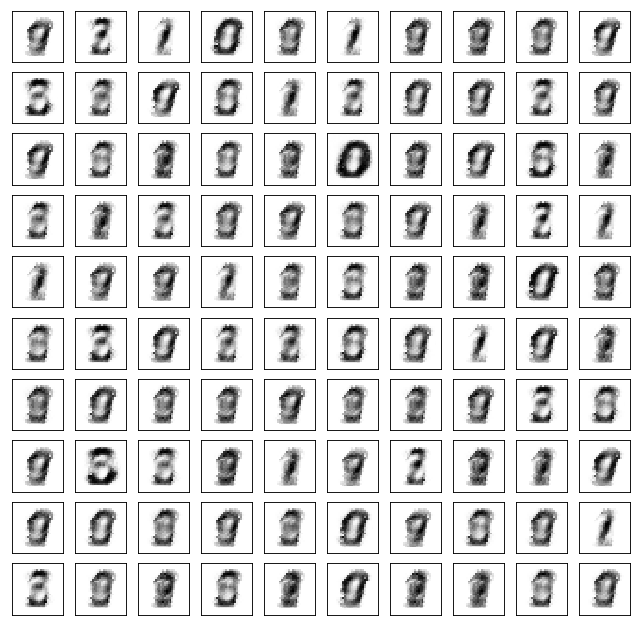

Test losses. E: 0.6877, AE: 0.2489, D: 0.7941
Train Epoch: 5 [0/50000 (0%)]	Losses E: 0.7099, AE: 0.2586, D: 0.8053
Train Epoch: 5 [25000/50000 (50%)]	Losses E: 0.5920, AE: 0.2193, D: 0.7204
Train Epoch: 5 [50000/50000 (100%)]	Losses E: 0.5709, AE: 0.2060, D: 0.7493


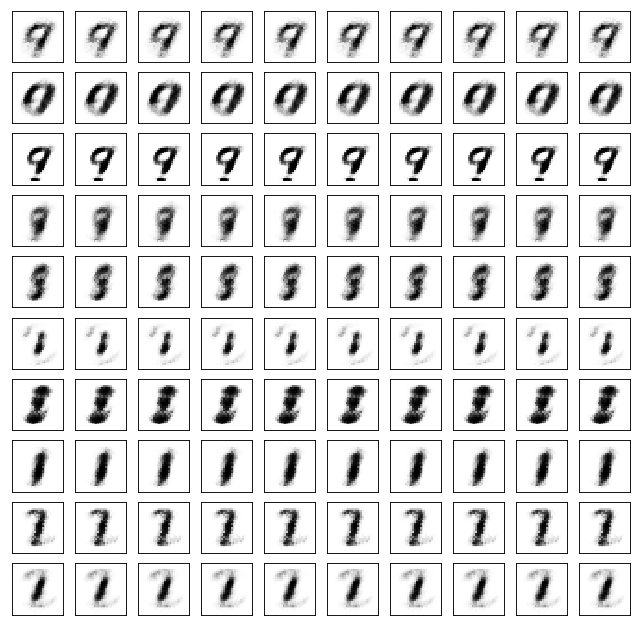

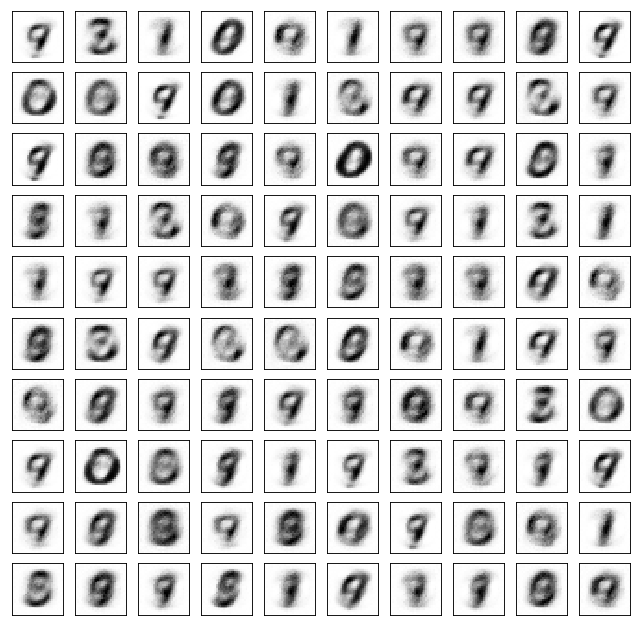

Test losses. E: 0.5584, AE: 0.2079, D: 0.7505
Train Epoch: 6 [0/50000 (0%)]	Losses E: 0.5690, AE: 0.2120, D: 0.7576
Train Epoch: 6 [25000/50000 (50%)]	Losses E: 0.6277, AE: 0.2015, D: 0.7528
Train Epoch: 6 [50000/50000 (100%)]	Losses E: 0.5924, AE: 0.1999, D: 0.7118


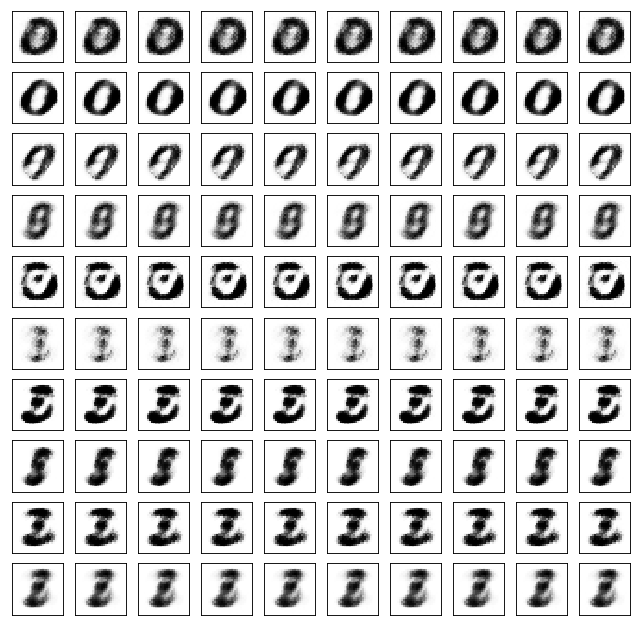

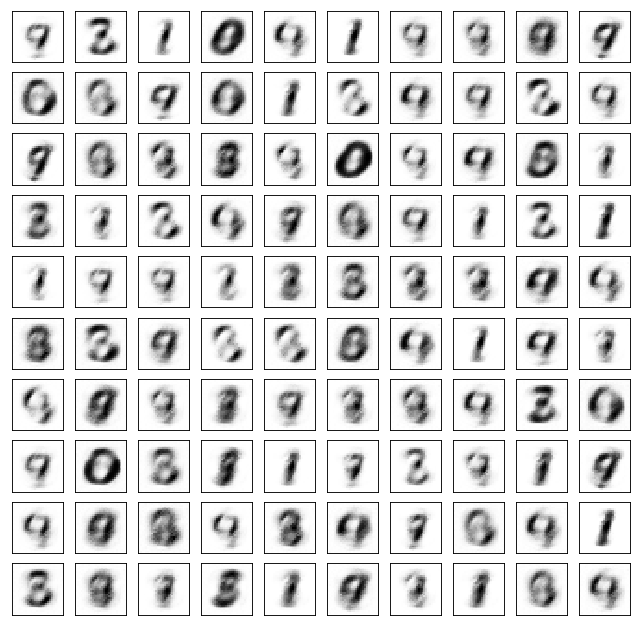

Test losses. E: 0.5850, AE: 0.2050, D: 0.7083
Train Epoch: 7 [0/50000 (0%)]	Losses E: 0.5989, AE: 0.1945, D: 0.7083
Train Epoch: 7 [25000/50000 (50%)]	Losses E: 0.6726, AE: 0.1934, D: 0.7517
Train Epoch: 7 [50000/50000 (100%)]	Losses E: 0.6695, AE: 0.1852, D: 0.7131


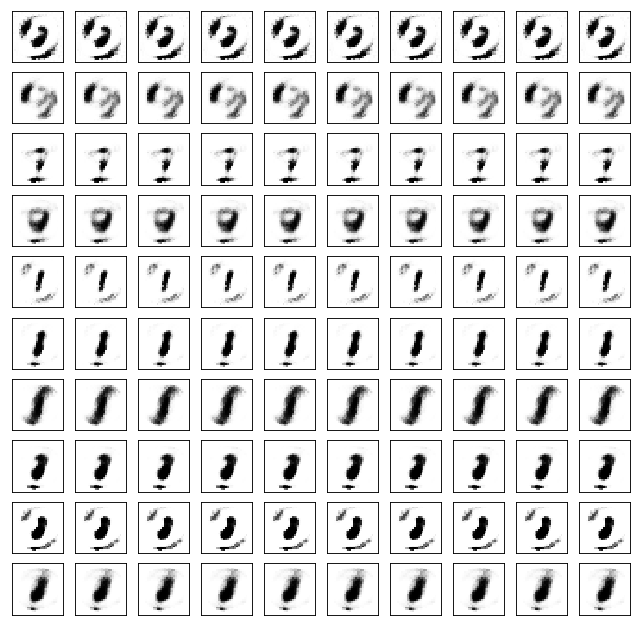

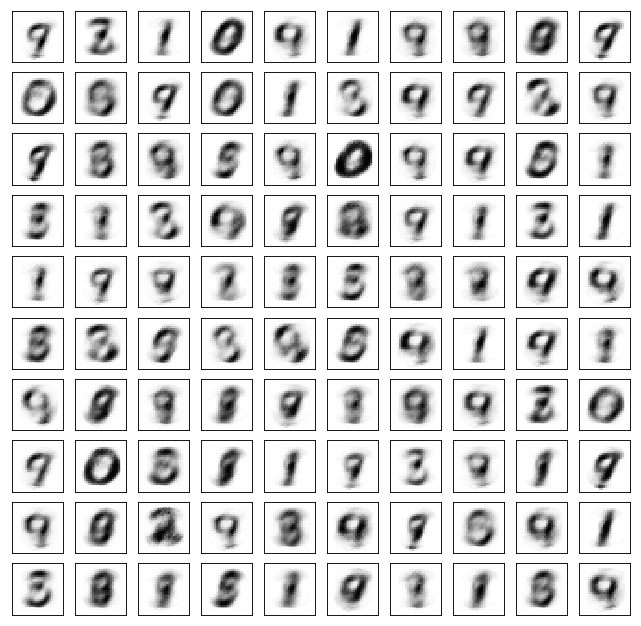

Test losses. E: 0.6660, AE: 0.1870, D: 0.7068
Train Epoch: 8 [0/50000 (0%)]	Losses E: 0.6723, AE: 0.1826, D: 0.7112
Train Epoch: 8 [25000/50000 (50%)]	Losses E: 0.9221, AE: 0.1869, D: 0.5888
Train Epoch: 8 [50000/50000 (100%)]	Losses E: 0.6875, AE: 0.1866, D: 0.7576


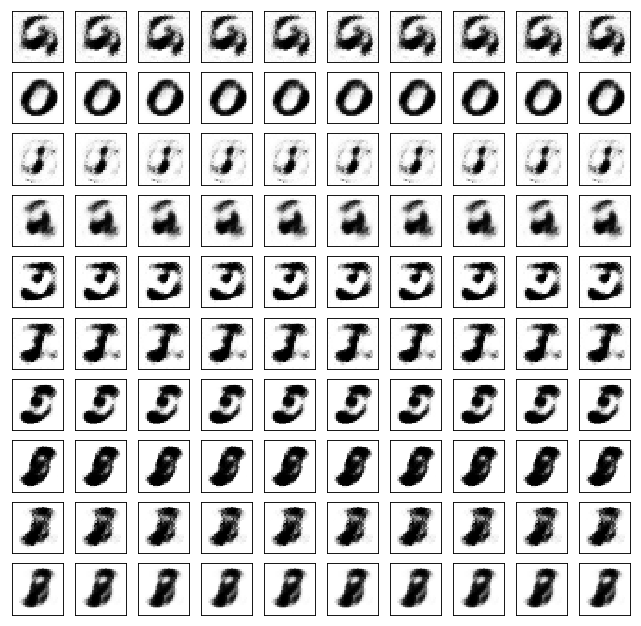

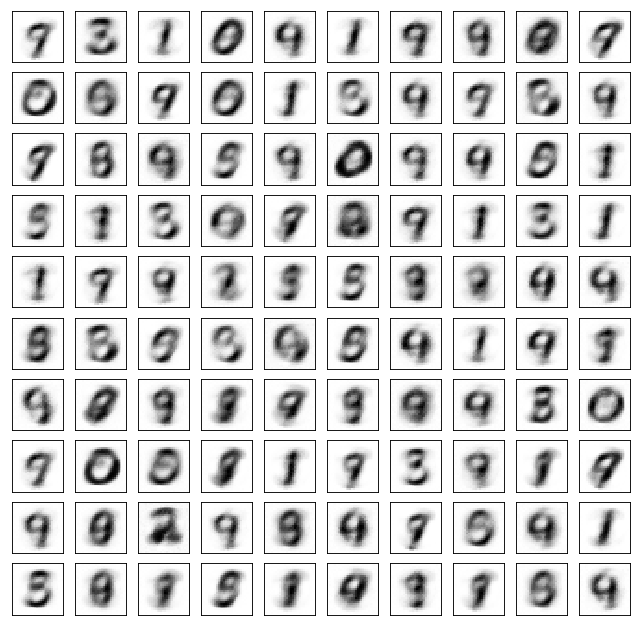

Test losses. E: 0.6869, AE: 0.1811, D: 0.7551
Train Epoch: 9 [0/50000 (0%)]	Losses E: 0.6877, AE: 0.1799, D: 0.7549
Train Epoch: 9 [25000/50000 (50%)]	Losses E: 0.6207, AE: 0.1687, D: 0.6813
Train Epoch: 9 [50000/50000 (100%)]	Losses E: 0.5255, AE: 0.1911, D: 0.7964


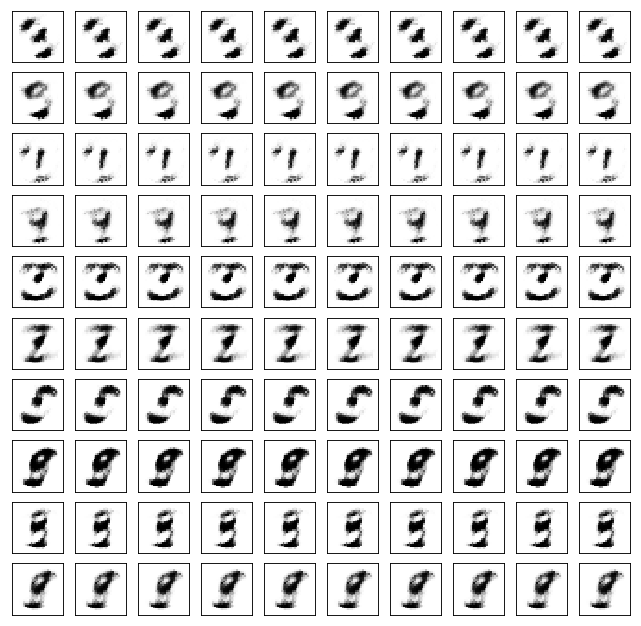

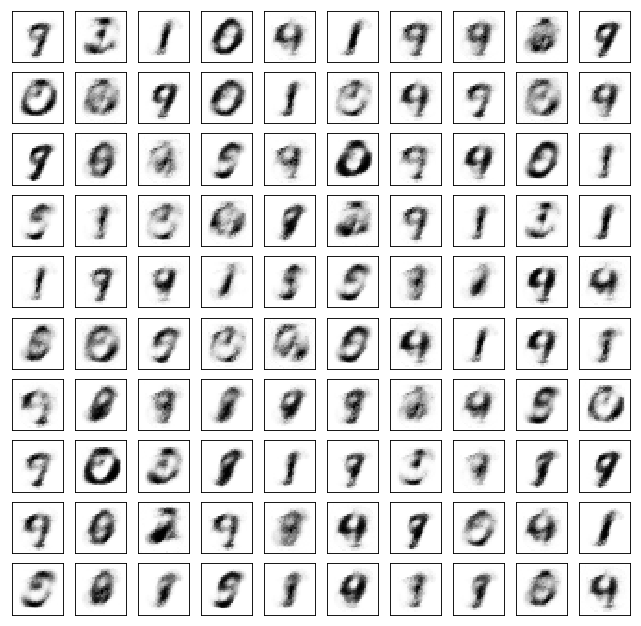

Test losses. E: 0.5001, AE: 0.1921, D: 0.7981
Train Epoch: 10 [0/50000 (0%)]	Losses E: 0.5285, AE: 0.1954, D: 0.7961
Train Epoch: 10 [25000/50000 (50%)]	Losses E: 0.6740, AE: 0.1744, D: 0.7486
Train Epoch: 10 [50000/50000 (100%)]	Losses E: 0.6754, AE: 0.1594, D: 0.6675


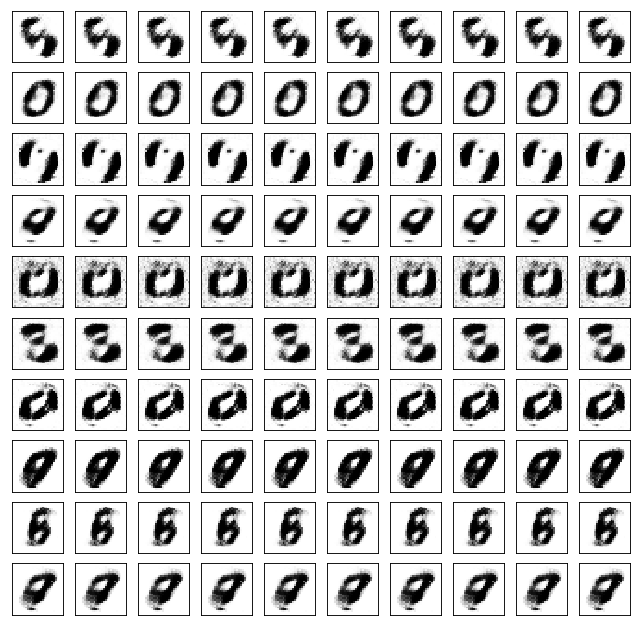

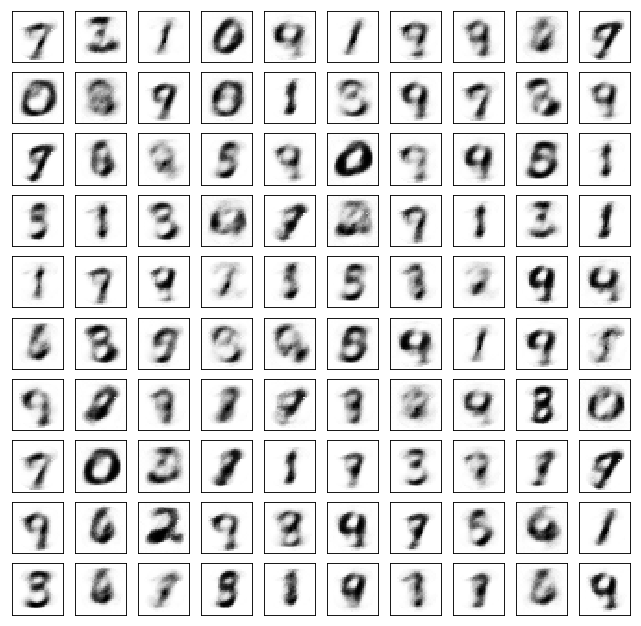

Test losses. E: 0.6745, AE: 0.1576, D: 0.6616
Train Epoch: 11 [0/50000 (0%)]	Losses E: 0.6795, AE: 0.1586, D: 0.6632
Train Epoch: 11 [25000/50000 (50%)]	Losses E: 0.6774, AE: 0.1687, D: 0.7754
Train Epoch: 11 [50000/50000 (100%)]	Losses E: 0.6816, AE: 0.1576, D: 0.7187


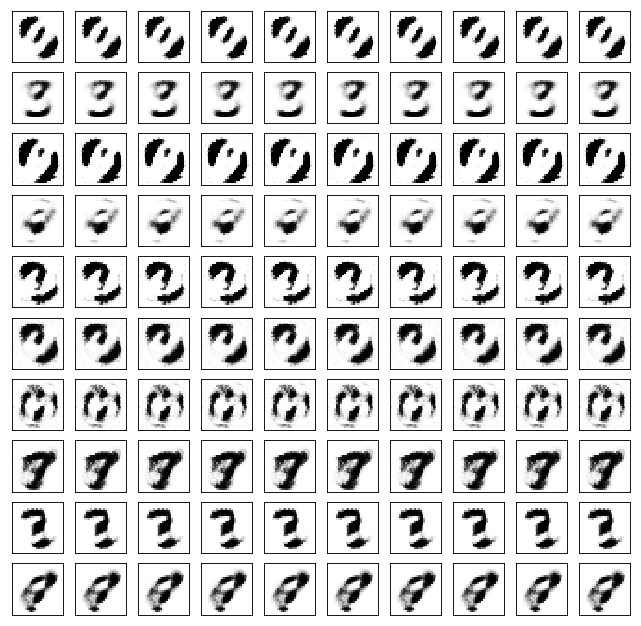

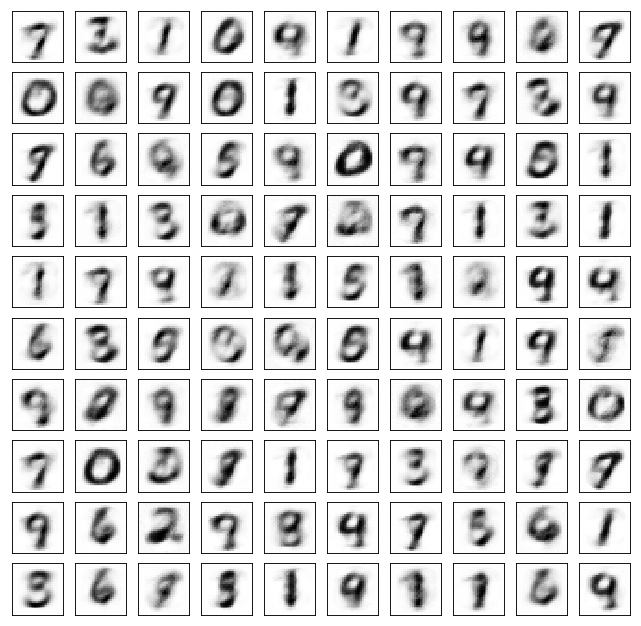

Test losses. E: 0.6788, AE: 0.1536, D: 0.7154
Train Epoch: 12 [0/50000 (0%)]	Losses E: 0.6786, AE: 0.1549, D: 0.7176
Train Epoch: 12 [25000/50000 (50%)]	Losses E: 0.6997, AE: 0.1490, D: 0.6504
Train Epoch: 12 [50000/50000 (100%)]	Losses E: 0.7629, AE: 0.1655, D: 0.7594


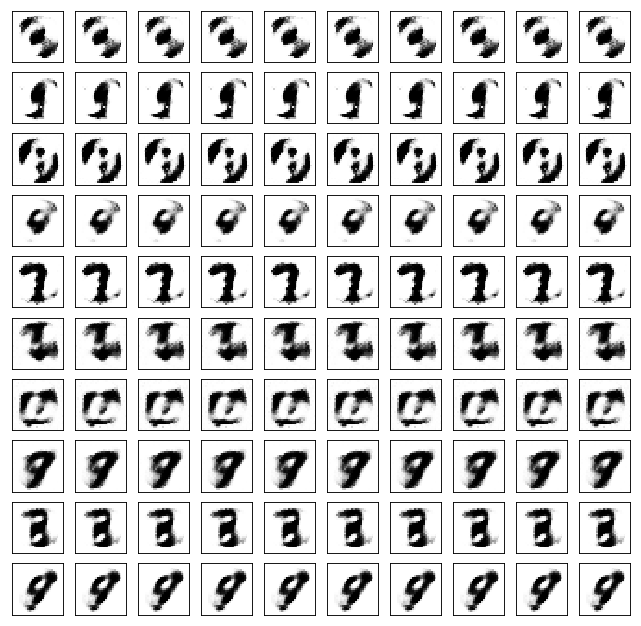

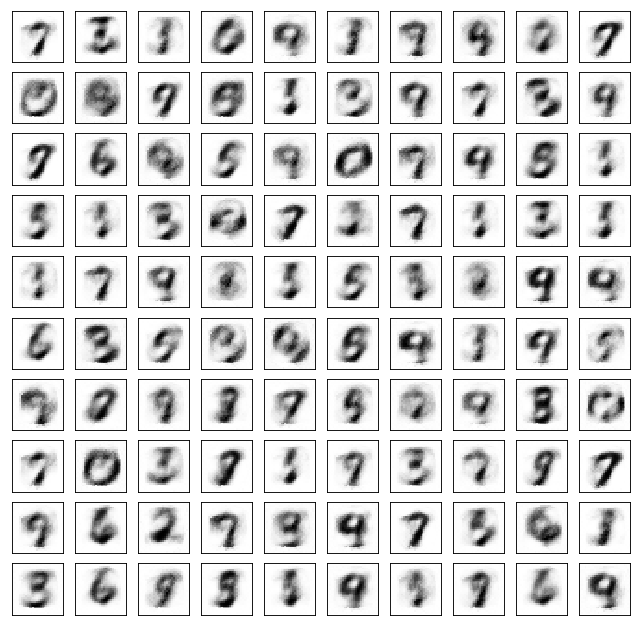

Test losses. E: 0.7555, AE: 0.1690, D: 0.7605
Train Epoch: 13 [0/50000 (0%)]	Losses E: 0.7587, AE: 0.1698, D: 0.7661
Train Epoch: 13 [25000/50000 (50%)]	Losses E: 0.7652, AE: 0.1516, D: 0.6657
Train Epoch: 13 [50000/50000 (100%)]	Losses E: 0.6522, AE: 0.1594, D: 0.7124


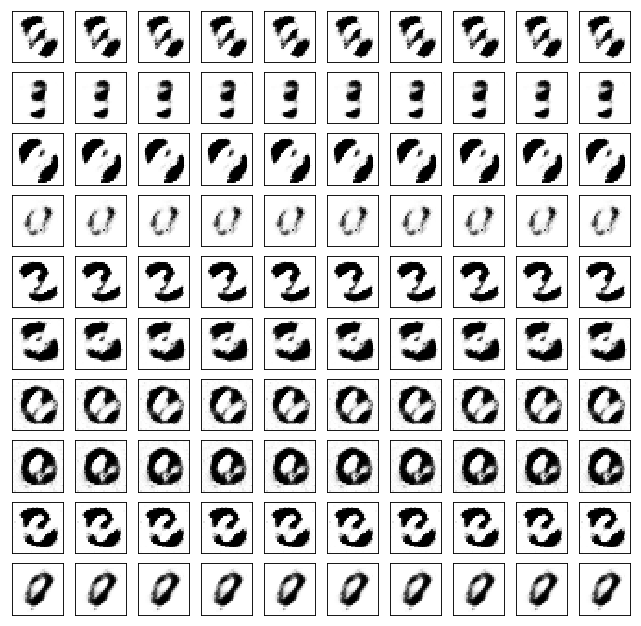

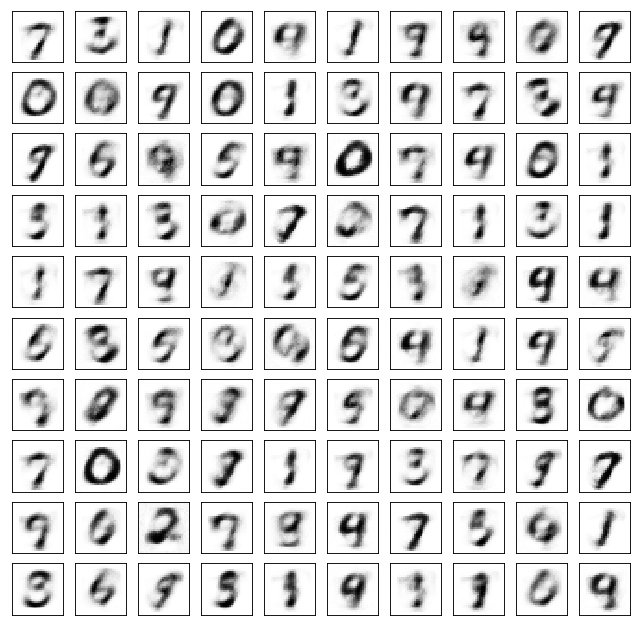

Test losses. E: 0.6464, AE: 0.1566, D: 0.7117
Train Epoch: 14 [0/50000 (0%)]	Losses E: 0.6515, AE: 0.1555, D: 0.7134
Train Epoch: 14 [25000/50000 (50%)]	Losses E: 0.6418, AE: 0.1528, D: 0.7501
Train Epoch: 14 [50000/50000 (100%)]	Losses E: 0.6325, AE: 0.1449, D: 0.7011


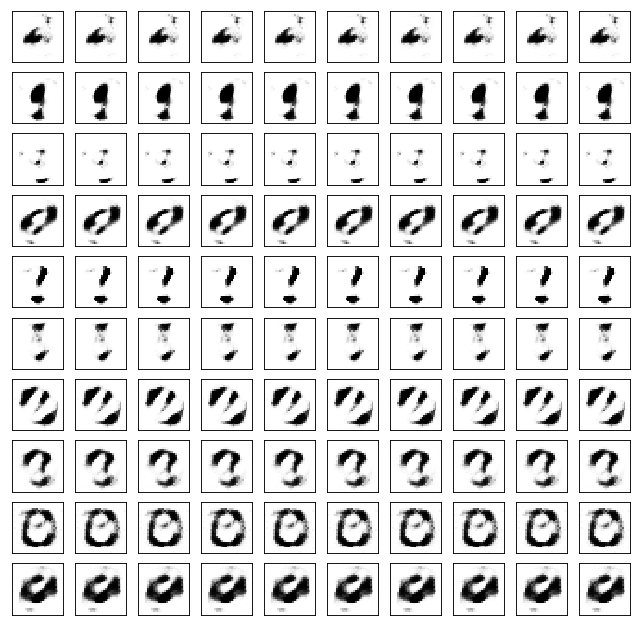

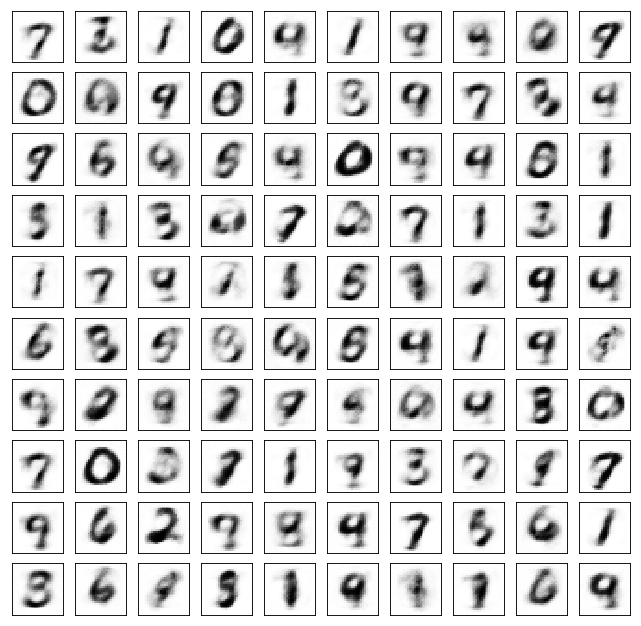

Test losses. E: 0.6279, AE: 0.1462, D: 0.7081
Train Epoch: 15 [0/50000 (0%)]	Losses E: 0.6283, AE: 0.1453, D: 0.7103
Train Epoch: 15 [25000/50000 (50%)]	Losses E: 0.6750, AE: 0.1663, D: 0.7120
Train Epoch: 15 [50000/50000 (100%)]	Losses E: 0.6545, AE: 0.1435, D: 0.7355


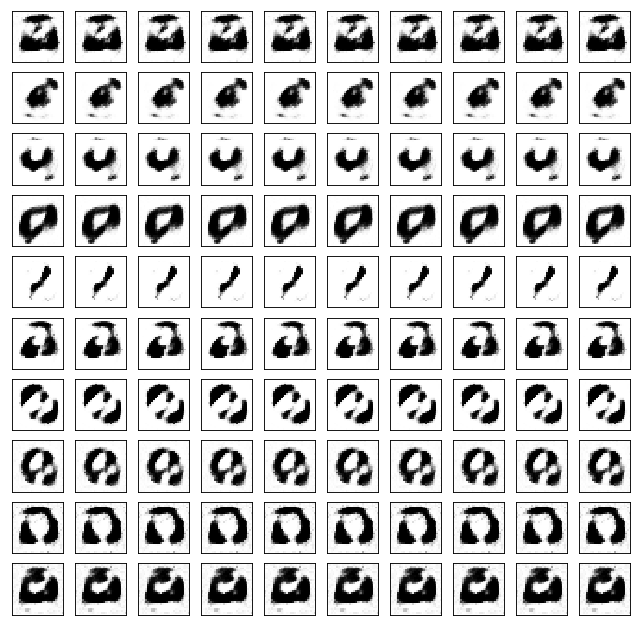

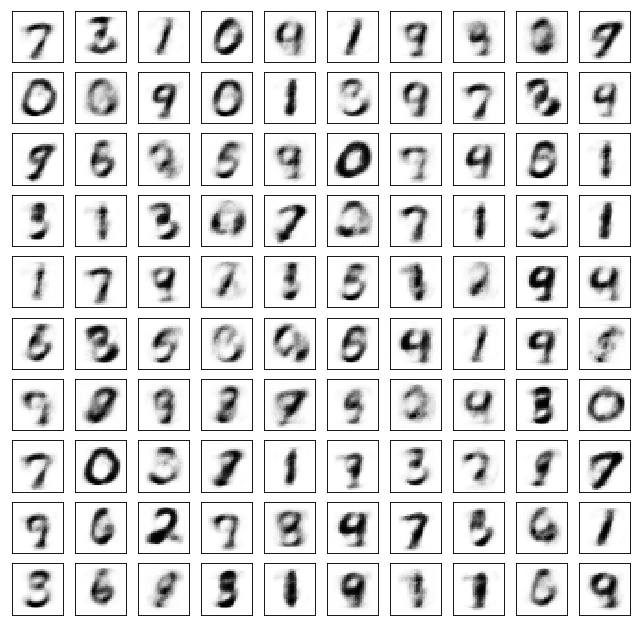

Test losses. E: 0.6513, AE: 0.1422, D: 0.7310
Train Epoch: 16 [0/50000 (0%)]	Losses E: 0.6525, AE: 0.1467, D: 0.7330
Train Epoch: 16 [25000/50000 (50%)]	Losses E: 0.6692, AE: 0.1388, D: 0.7028
Train Epoch: 16 [50000/50000 (100%)]	Losses E: 0.5999, AE: 0.1595, D: 0.7220


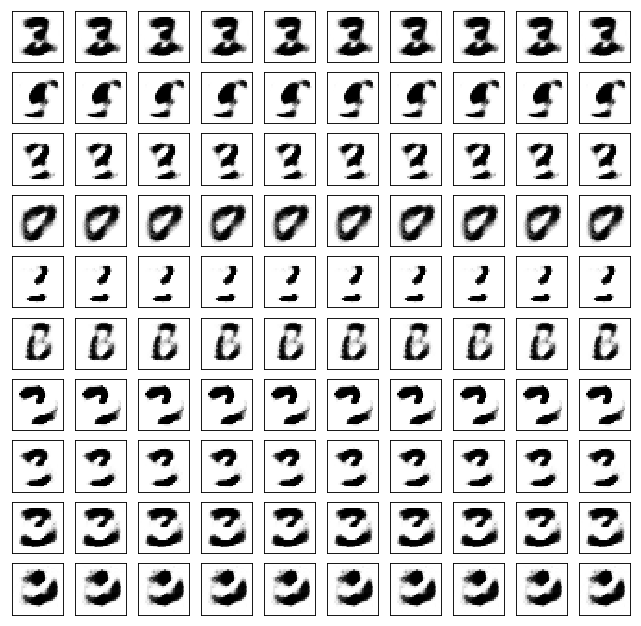

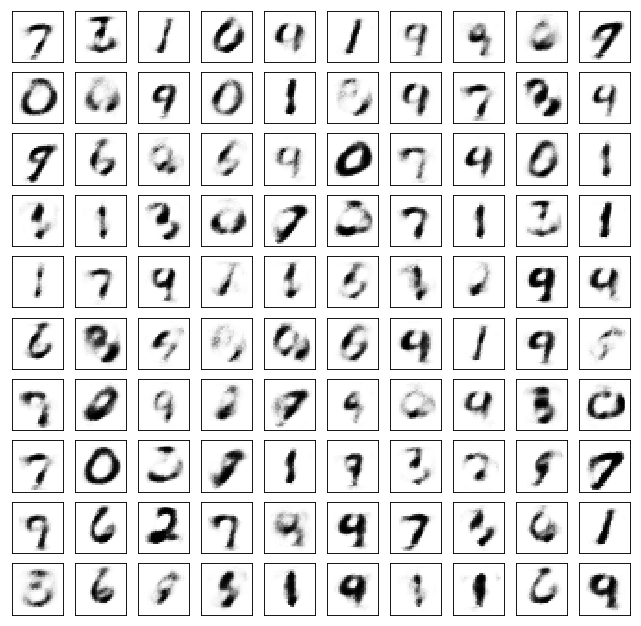

Test losses. E: 0.5817, AE: 0.1588, D: 0.7213
Train Epoch: 17 [0/50000 (0%)]	Losses E: 0.5964, AE: 0.1526, D: 0.7227
Train Epoch: 17 [25000/50000 (50%)]	Losses E: 0.7315, AE: 0.1397, D: 0.7171
Train Epoch: 17 [50000/50000 (100%)]	Losses E: 0.6285, AE: 0.1547, D: 0.7156


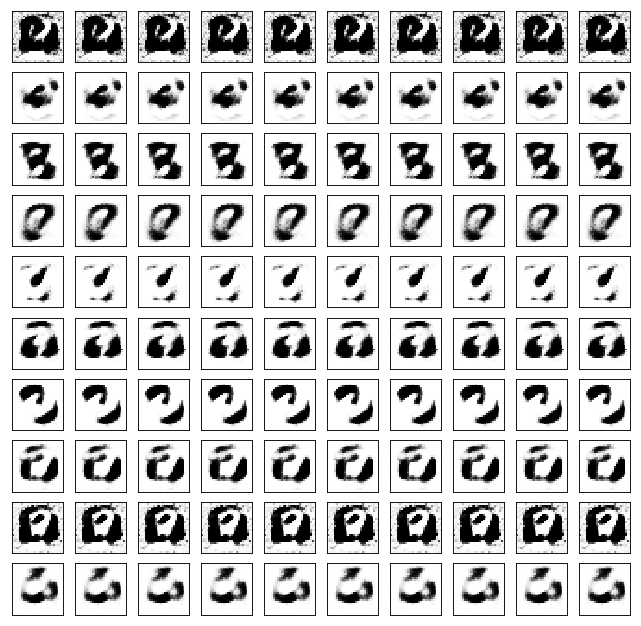

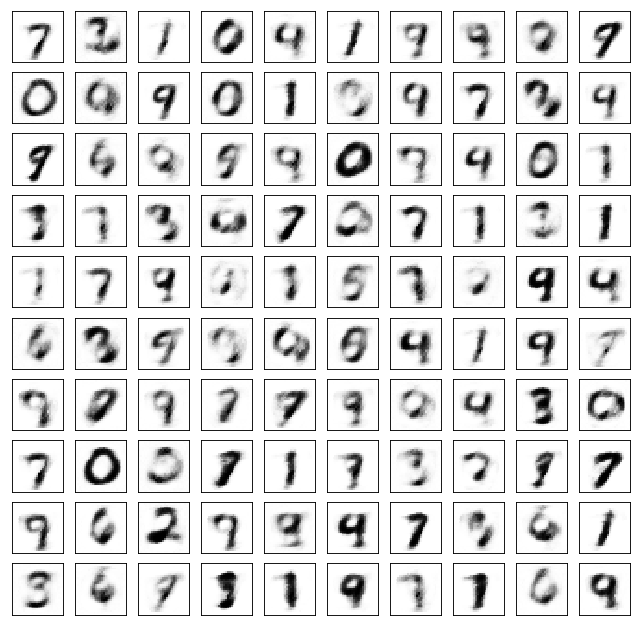

Test losses. E: 0.6270, AE: 0.1505, D: 0.7192
Train Epoch: 18 [0/50000 (0%)]	Losses E: 0.6309, AE: 0.1525, D: 0.7162
Train Epoch: 18 [25000/50000 (50%)]	Losses E: 0.7408, AE: 0.1466, D: 0.6706
Train Epoch: 18 [50000/50000 (100%)]	Losses E: 0.7103, AE: 0.1633, D: 0.7447


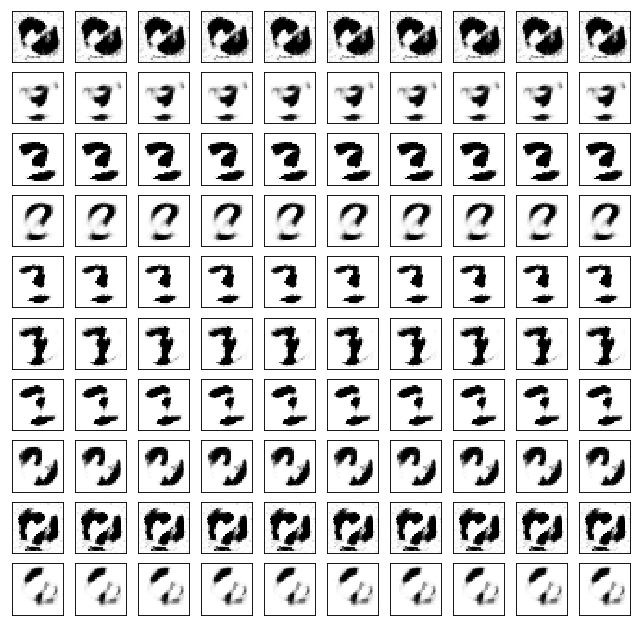

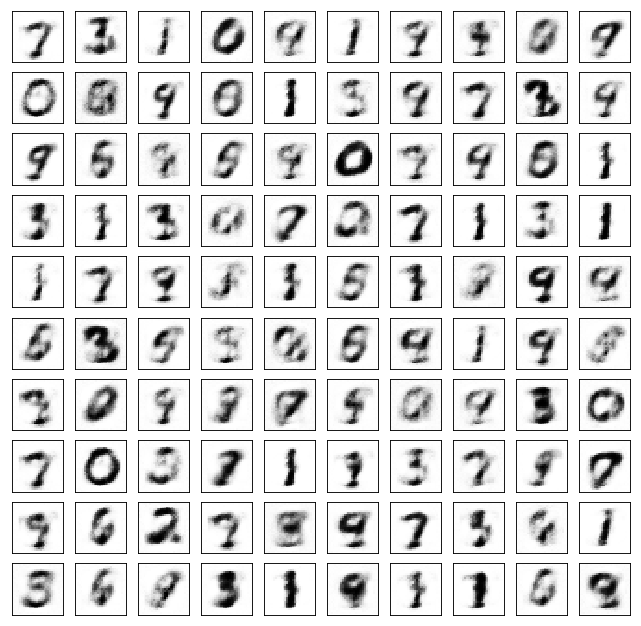

Test losses. E: 0.7031, AE: 0.1585, D: 0.7367
Train Epoch: 19 [0/50000 (0%)]	Losses E: 0.7089, AE: 0.1637, D: 0.7378
Train Epoch: 19 [25000/50000 (50%)]	Losses E: 0.6330, AE: 0.1330, D: 0.6888
Train Epoch: 19 [50000/50000 (100%)]	Losses E: 0.9437, AE: 0.2648, D: 0.7337


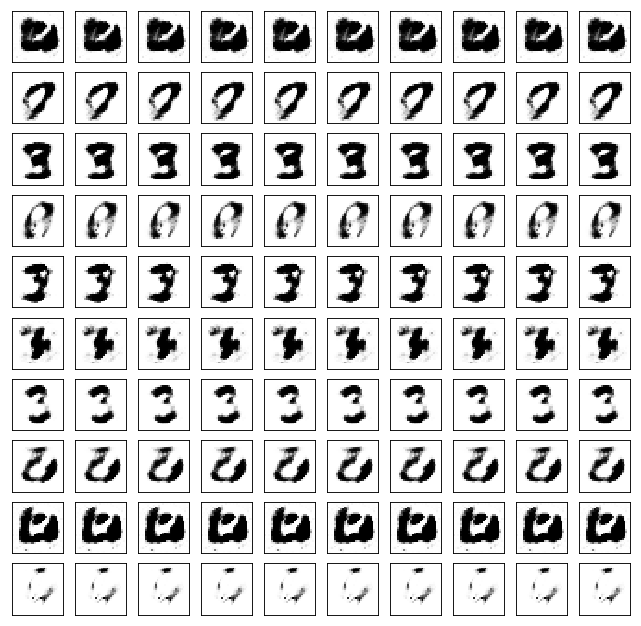

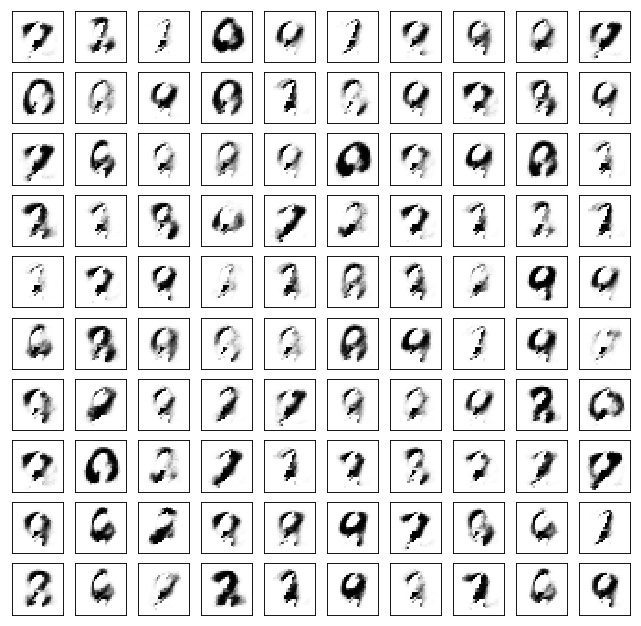

Test losses. E: 0.8930, AE: 0.2621, D: 0.7389
Train Epoch: 20 [0/50000 (0%)]	Losses E: 0.9293, AE: 0.2637, D: 0.7400
Train Epoch: 20 [25000/50000 (50%)]	Losses E: 0.6486, AE: 0.1424, D: 0.6726
Train Epoch: 20 [50000/50000 (100%)]	Losses E: 0.9944, AE: 0.1863, D: 0.6726


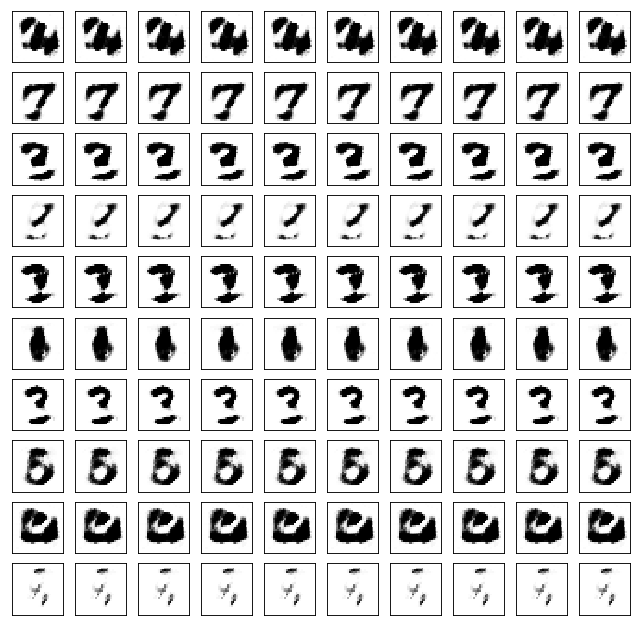

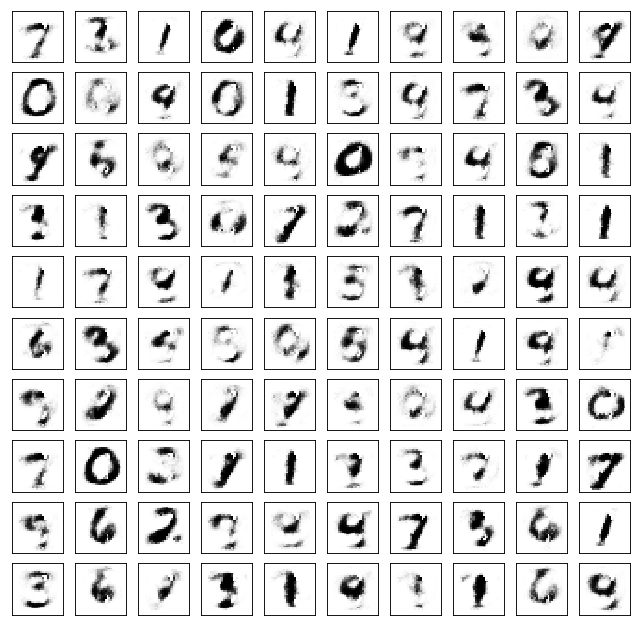

Test losses. E: 0.9336, AE: 0.1848, D: 0.6723
Train Epoch: 21 [0/50000 (0%)]	Losses E: 1.0003, AE: 0.1894, D: 0.6779
Train Epoch: 21 [25000/50000 (50%)]	Losses E: 0.6826, AE: 0.1333, D: 0.6971
Train Epoch: 21 [50000/50000 (100%)]	Losses E: 1.0251, AE: 0.4167, D: 0.7678


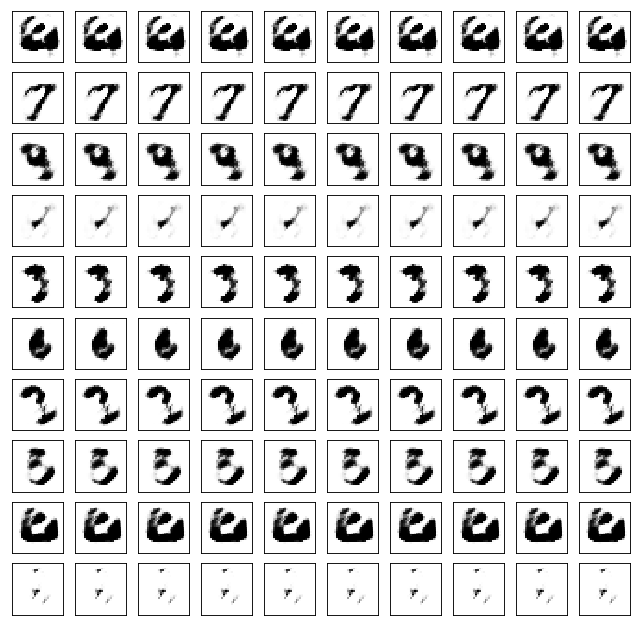

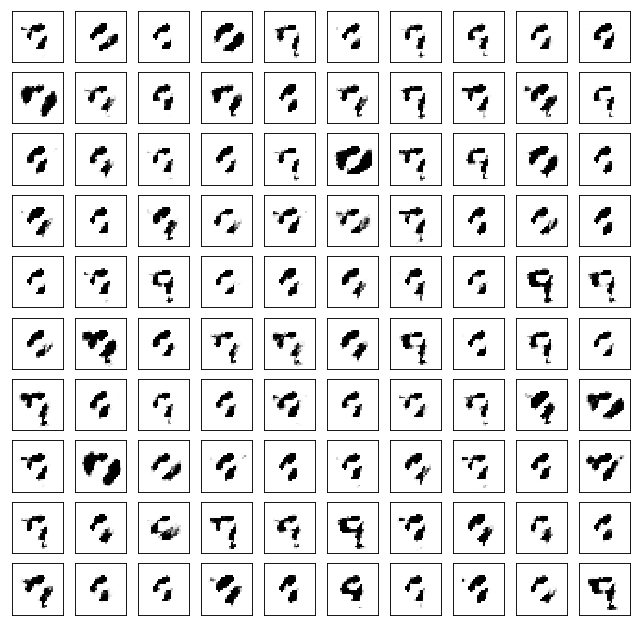

Test losses. E: 0.7986, AE: 0.4228, D: 0.7311
Train Epoch: 22 [0/50000 (0%)]	Losses E: 1.1298, AE: 0.4088, D: 0.7348
Train Epoch: 22 [25000/50000 (50%)]	Losses E: 0.6626, AE: 0.1486, D: 0.7200
Train Epoch: 22 [50000/50000 (100%)]	Losses E: 0.6242, AE: 0.1372, D: 0.6645


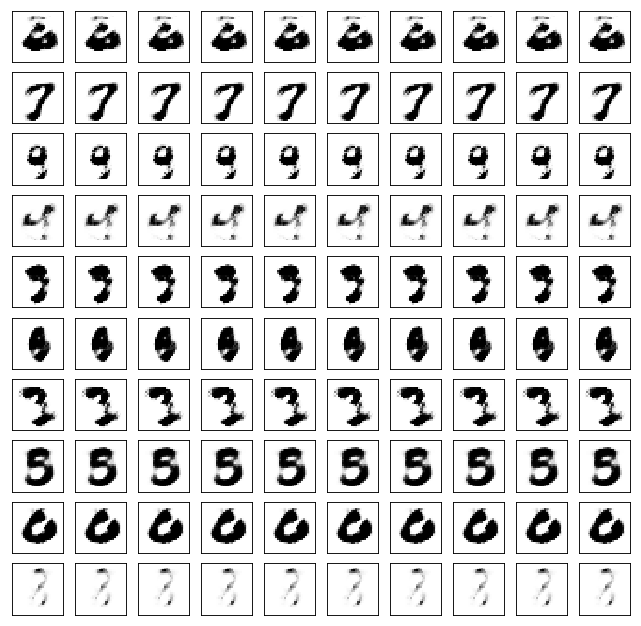

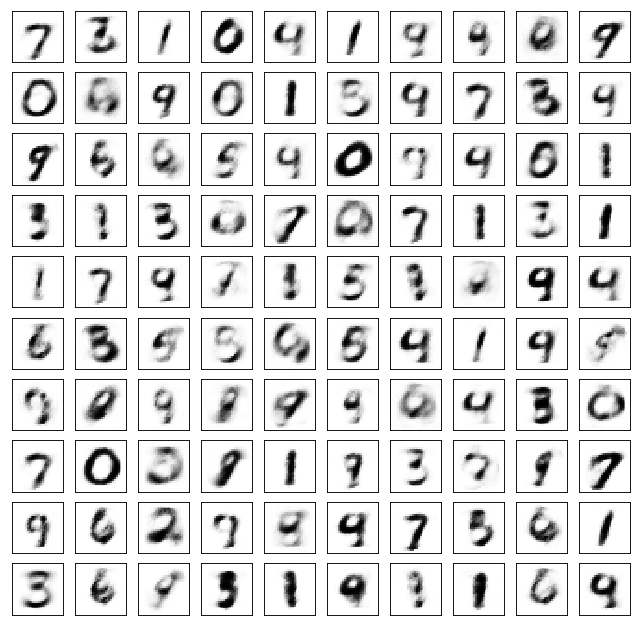

Test losses. E: 0.6223, AE: 0.1384, D: 0.6648
Train Epoch: 23 [0/50000 (0%)]	Losses E: 0.6238, AE: 0.1380, D: 0.6657
Train Epoch: 23 [25000/50000 (50%)]	Losses E: 1.5556, AE: 0.3232, D: 0.6060
Train Epoch: 23 [50000/50000 (100%)]	Losses E: 0.7064, AE: 0.1427, D: 0.7035


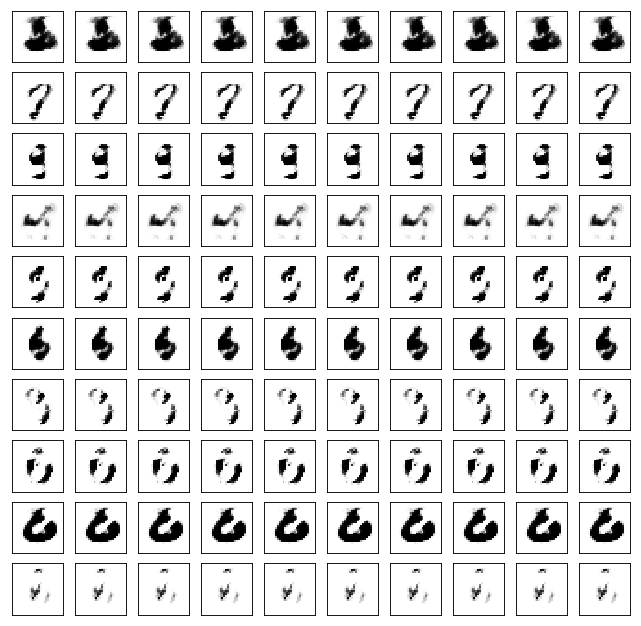

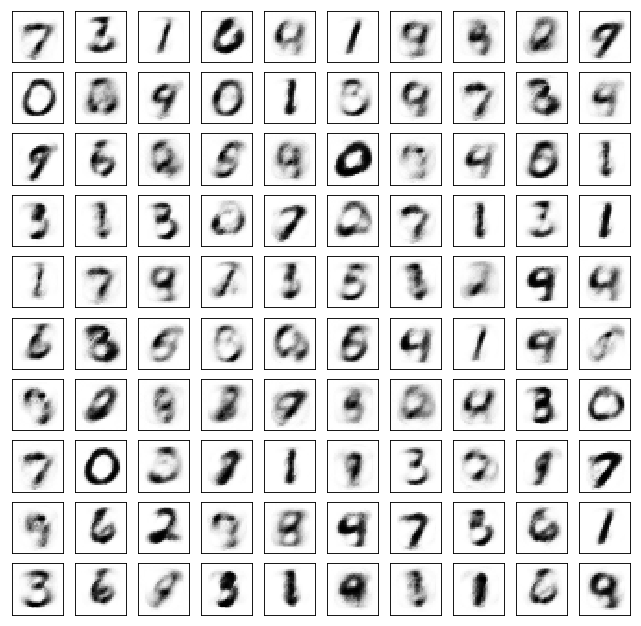

Test losses. E: 0.7040, AE: 0.1369, D: 0.6991
Train Epoch: 24 [0/50000 (0%)]	Losses E: 0.7059, AE: 0.1364, D: 0.7023
Train Epoch: 24 [25000/50000 (50%)]	Losses E: 0.6458, AE: 0.1500, D: 0.7000
Train Epoch: 24 [50000/50000 (100%)]	Losses E: 0.7250, AE: 0.1515, D: 0.7587


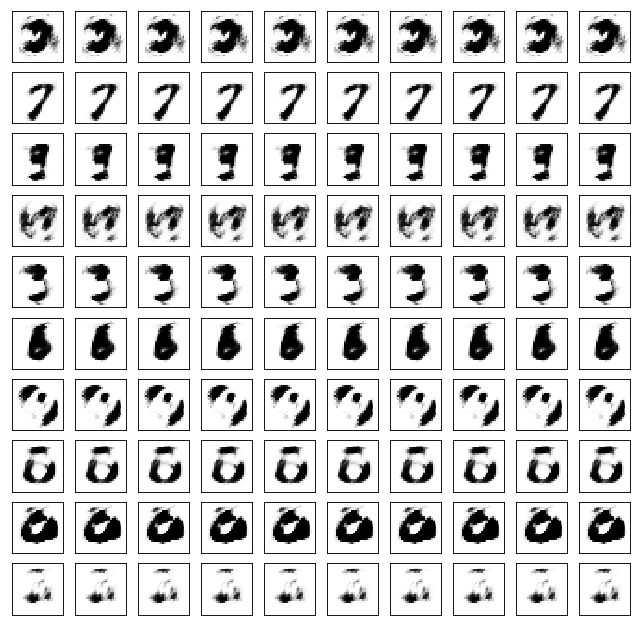

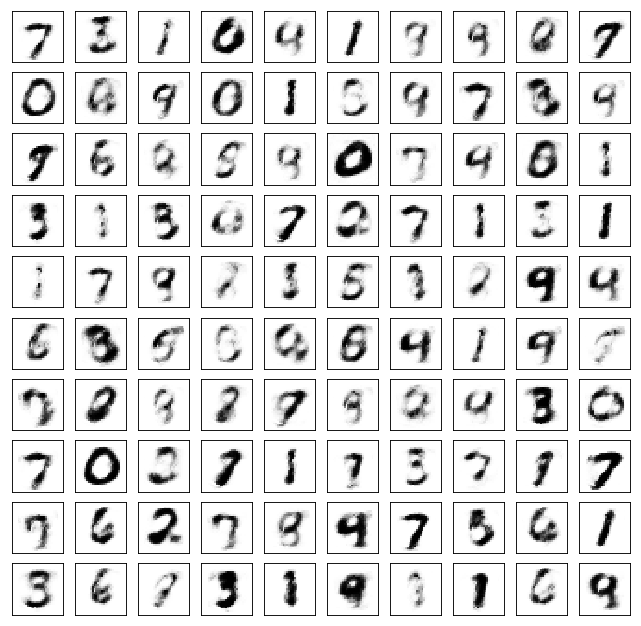

Test losses. E: 0.7237, AE: 0.1496, D: 0.7515
Train Epoch: 25 [0/50000 (0%)]	Losses E: 0.7386, AE: 0.1424, D: 0.7541
Train Epoch: 25 [25000/50000 (50%)]	Losses E: 0.6493, AE: 0.1345, D: 0.6954
Train Epoch: 25 [50000/50000 (100%)]	Losses E: 0.6928, AE: 0.1361, D: 0.6815


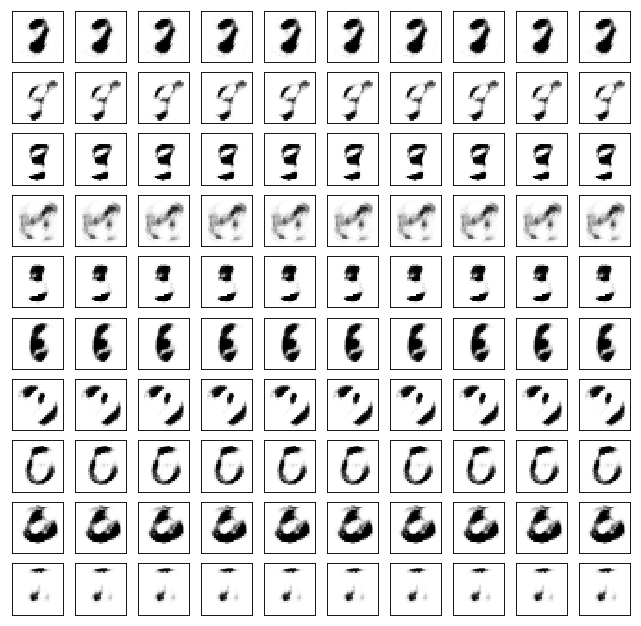

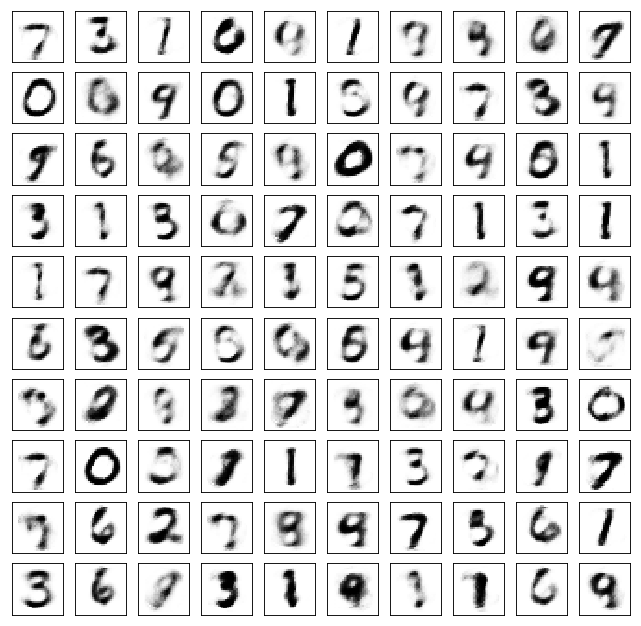

Test losses. E: 0.6854, AE: 0.1373, D: 0.6808
Train Epoch: 26 [0/50000 (0%)]	Losses E: 0.6960, AE: 0.1356, D: 0.6820
Train Epoch: 26 [25000/50000 (50%)]	Losses E: 0.6977, AE: 0.1353, D: 0.7130
Train Epoch: 26 [50000/50000 (100%)]	Losses E: 0.6598, AE: 0.1370, D: 0.7135


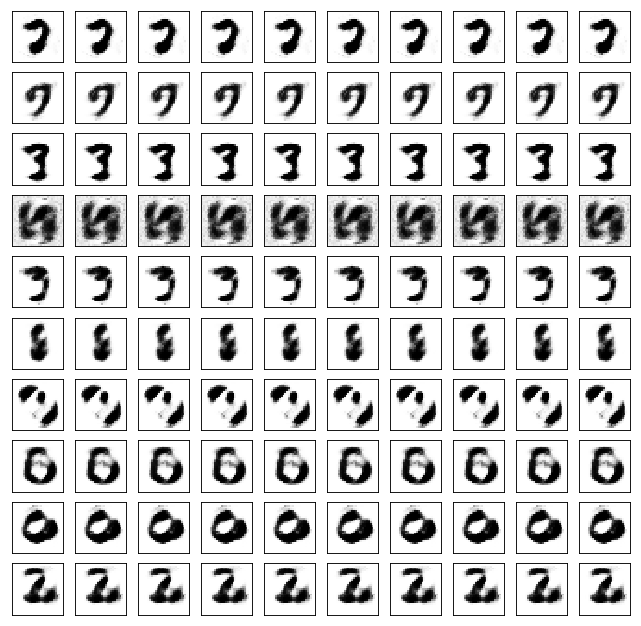

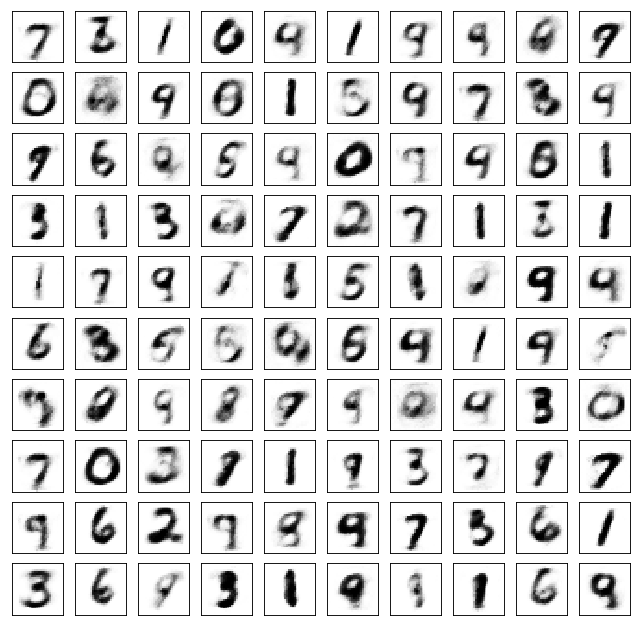

Test losses. E: 0.6566, AE: 0.1322, D: 0.7097
Train Epoch: 27 [0/50000 (0%)]	Losses E: 0.6624, AE: 0.1274, D: 0.7088
Train Epoch: 27 [25000/50000 (50%)]	Losses E: 0.7259, AE: 0.1493, D: 0.6909
Train Epoch: 27 [50000/50000 (100%)]	Losses E: 0.6791, AE: 0.1179, D: 0.6976


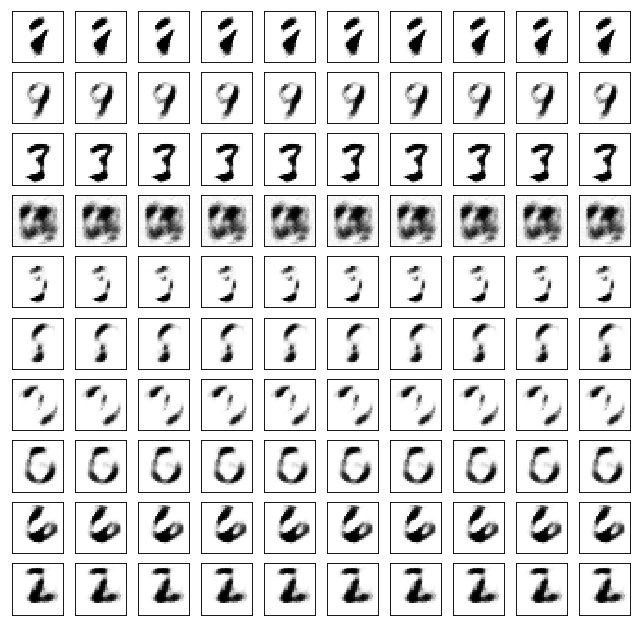

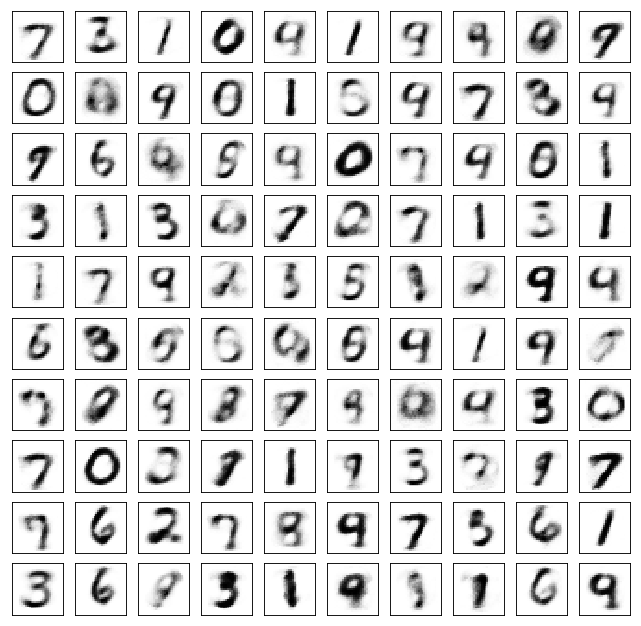

Test losses. E: 0.6768, AE: 0.1227, D: 0.6971
Train Epoch: 28 [0/50000 (0%)]	Losses E: 0.6841, AE: 0.1200, D: 0.6949
Train Epoch: 28 [25000/50000 (50%)]	Losses E: 0.7154, AE: 0.1284, D: 0.7087
Train Epoch: 28 [50000/50000 (100%)]	Losses E: 0.6837, AE: 0.1201, D: 0.6917


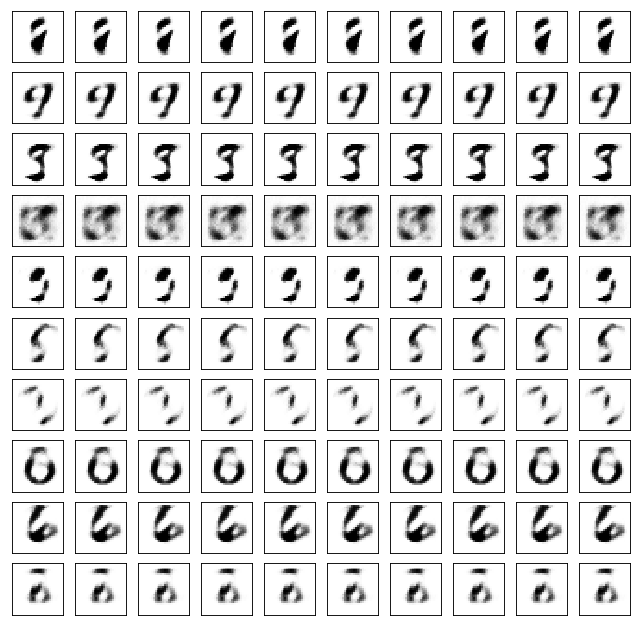

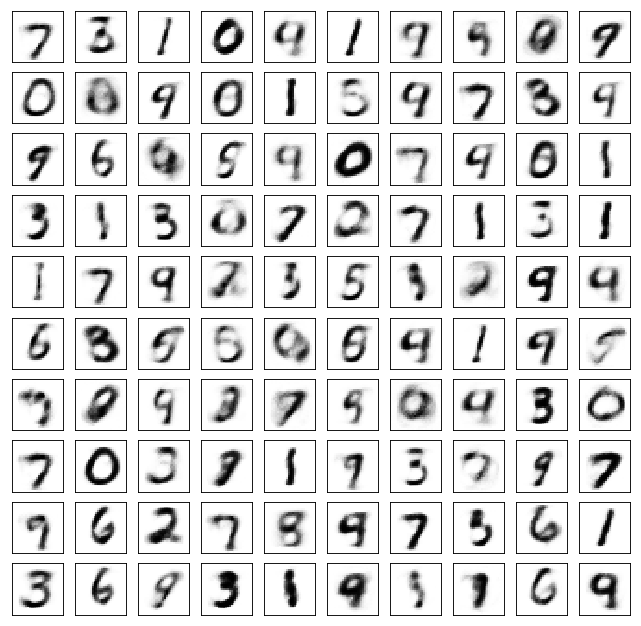

Test losses. E: 0.6828, AE: 0.1181, D: 0.6934
Train Epoch: 29 [0/50000 (0%)]	Losses E: 0.6818, AE: 0.1201, D: 0.6922
Train Epoch: 29 [25000/50000 (50%)]	Losses E: 0.6598, AE: 0.1197, D: 0.7157
Train Epoch: 29 [50000/50000 (100%)]	Losses E: 0.6931, AE: 0.1145, D: 0.6983


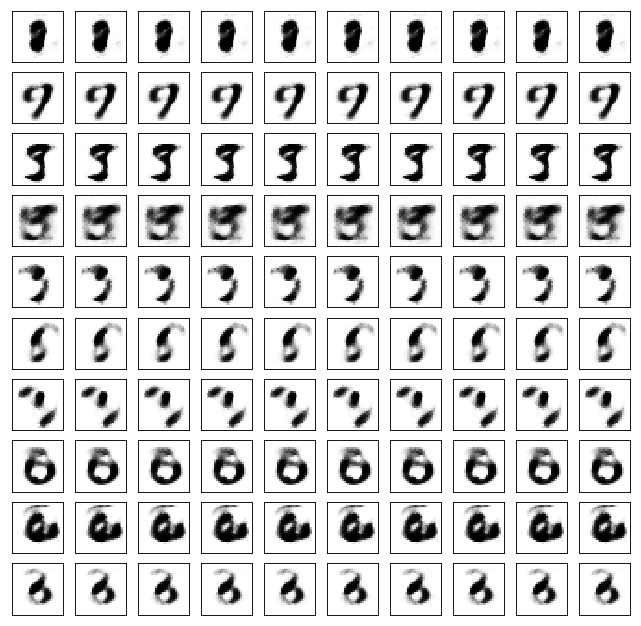

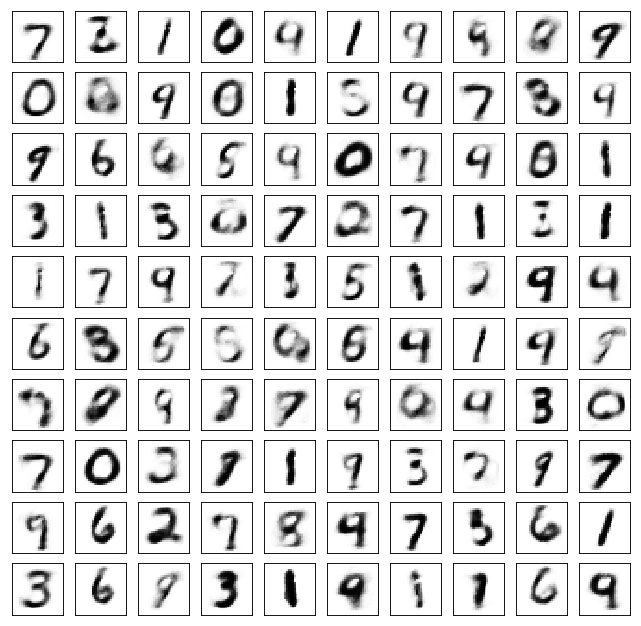

Test losses. E: 0.6927, AE: 0.1154, D: 0.6982
Train Epoch: 30 [0/50000 (0%)]	Losses E: 0.6985, AE: 0.1180, D: 0.6989
Train Epoch: 30 [25000/50000 (50%)]	Losses E: 0.6671, AE: 0.1182, D: 0.6852
Train Epoch: 30 [50000/50000 (100%)]	Losses E: 0.7088, AE: 0.1202, D: 0.6892


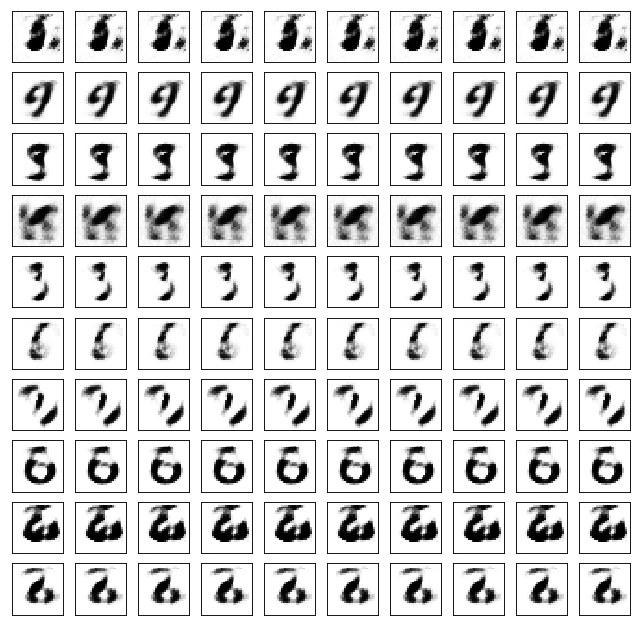

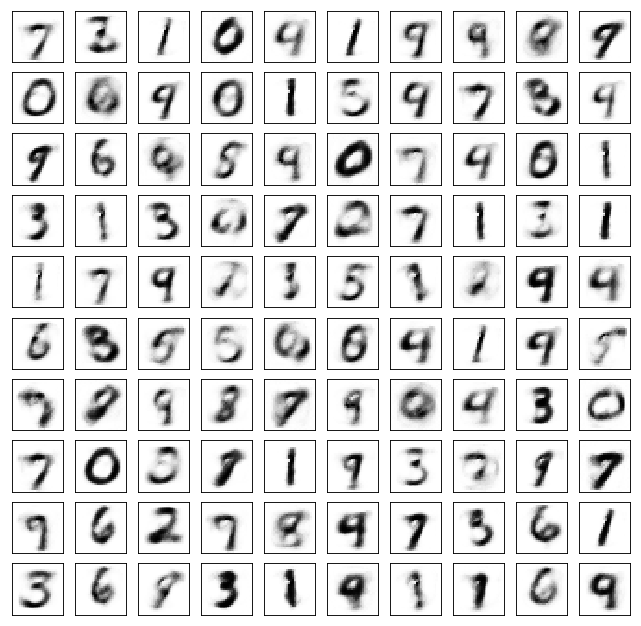

Test losses. E: 0.7049, AE: 0.1197, D: 0.6884
Train Epoch: 31 [0/50000 (0%)]	Losses E: 0.7046, AE: 0.1195, D: 0.6892
Train Epoch: 31 [25000/50000 (50%)]	Losses E: 0.6770, AE: 0.1312, D: 0.7240
Train Epoch: 31 [50000/50000 (100%)]	Losses E: 0.6922, AE: 0.1287, D: 0.7180


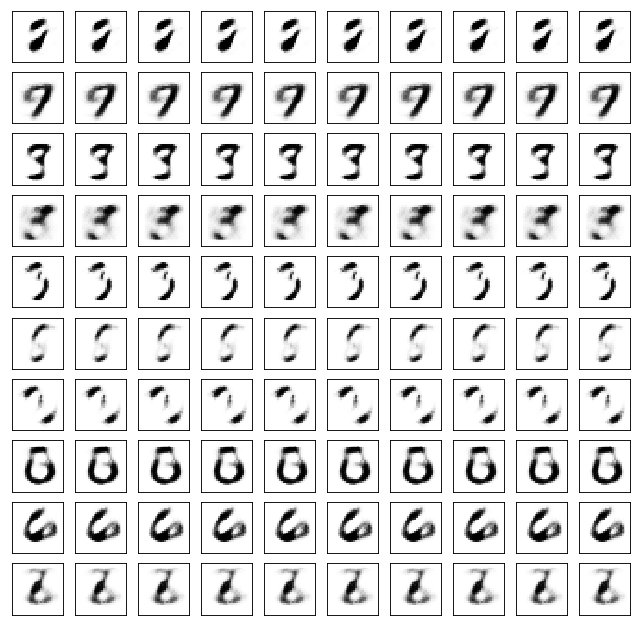

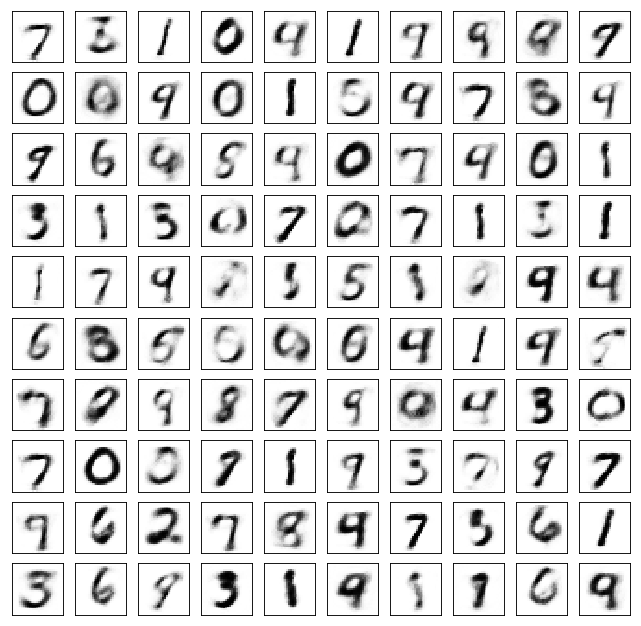

Test losses. E: 0.6862, AE: 0.1220, D: 0.7147
Train Epoch: 32 [0/50000 (0%)]	Losses E: 0.6906, AE: 0.1220, D: 0.7112
Train Epoch: 32 [25000/50000 (50%)]	Losses E: 0.6492, AE: 0.1160, D: 0.6995
Train Epoch: 32 [50000/50000 (100%)]	Losses E: 0.7131, AE: 0.1176, D: 0.7131


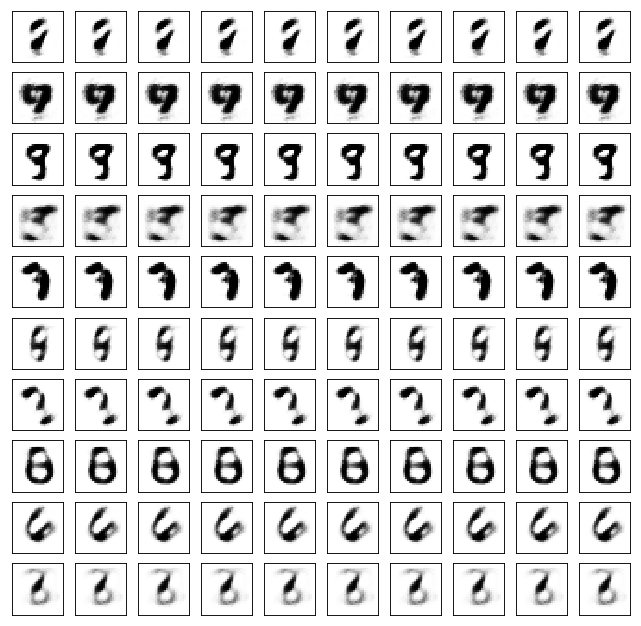

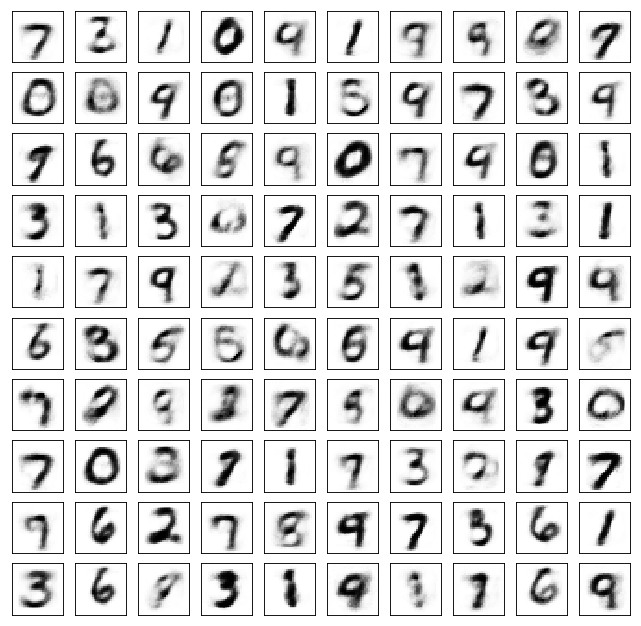

Test losses. E: 0.7115, AE: 0.1195, D: 0.7123
Train Epoch: 33 [0/50000 (0%)]	Losses E: 0.7147, AE: 0.1149, D: 0.7144
Train Epoch: 33 [25000/50000 (50%)]	Losses E: 0.6669, AE: 0.1074, D: 0.6973
Train Epoch: 33 [50000/50000 (100%)]	Losses E: 0.7250, AE: 0.1082, D: 0.7076


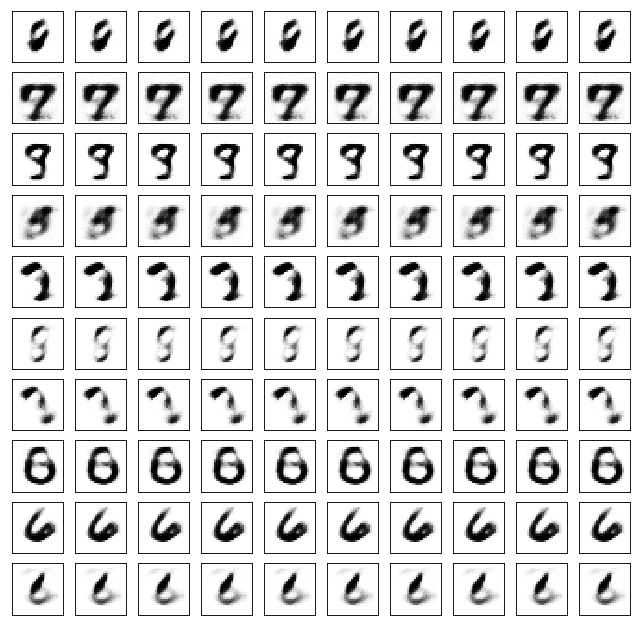

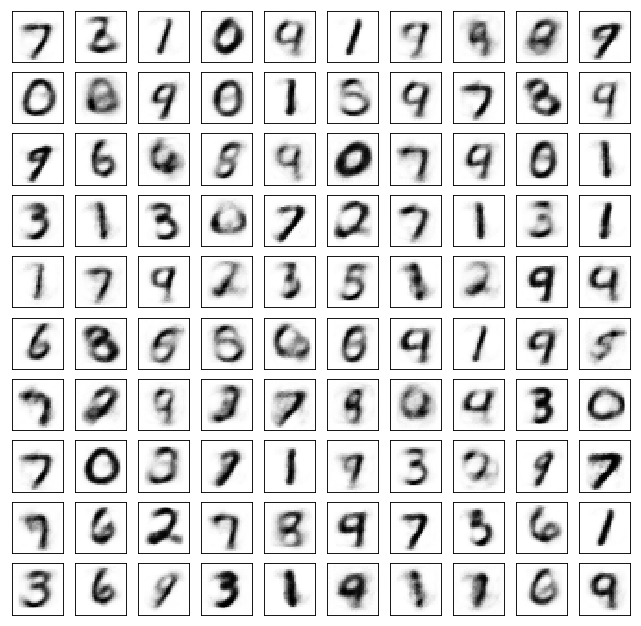

Test losses. E: 0.7221, AE: 0.1133, D: 0.7056
Train Epoch: 34 [0/50000 (0%)]	Losses E: 0.7219, AE: 0.1131, D: 0.7075
Train Epoch: 34 [25000/50000 (50%)]	Losses E: 0.6411, AE: 0.1042, D: 0.7099
Train Epoch: 34 [50000/50000 (100%)]	Losses E: 0.7185, AE: 0.1035, D: 0.6978


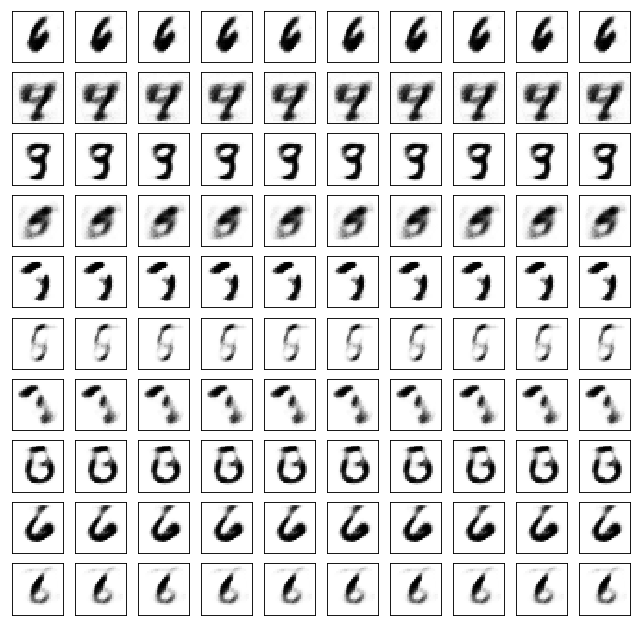

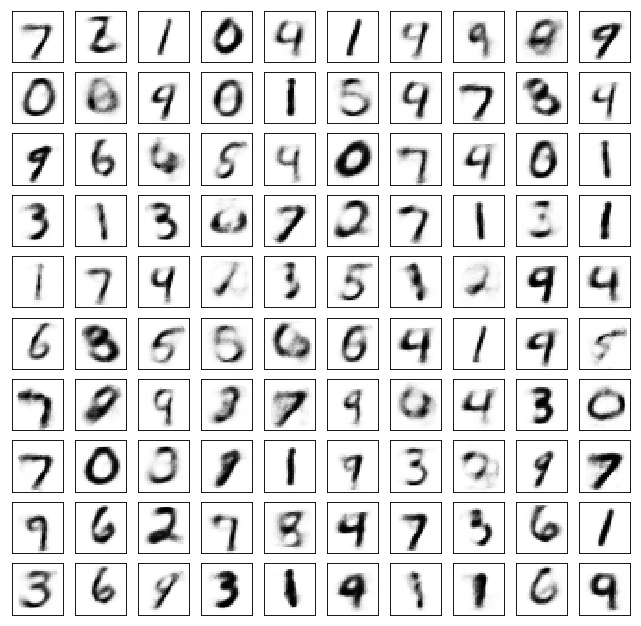

Test losses. E: 0.7186, AE: 0.1048, D: 0.6955
Train Epoch: 35 [0/50000 (0%)]	Losses E: 0.7253, AE: 0.1098, D: 0.6949
Train Epoch: 35 [25000/50000 (50%)]	Losses E: 0.6507, AE: 0.1057, D: 0.7064
Train Epoch: 35 [50000/50000 (100%)]	Losses E: 0.7267, AE: 0.0979, D: 0.6792


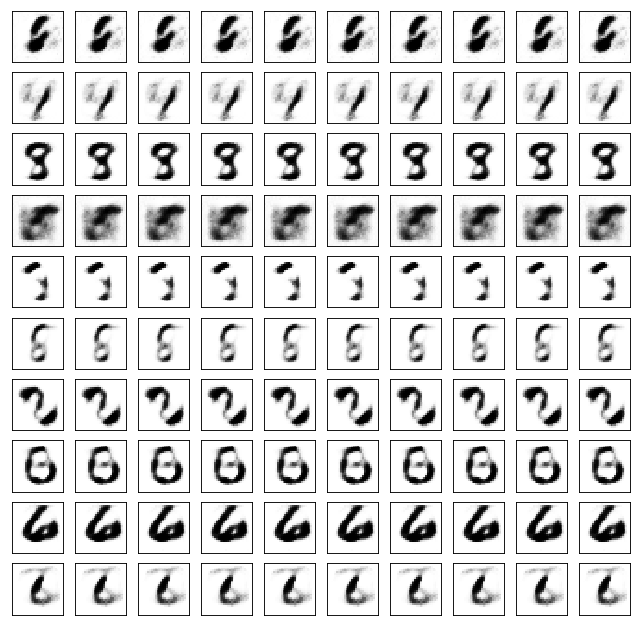

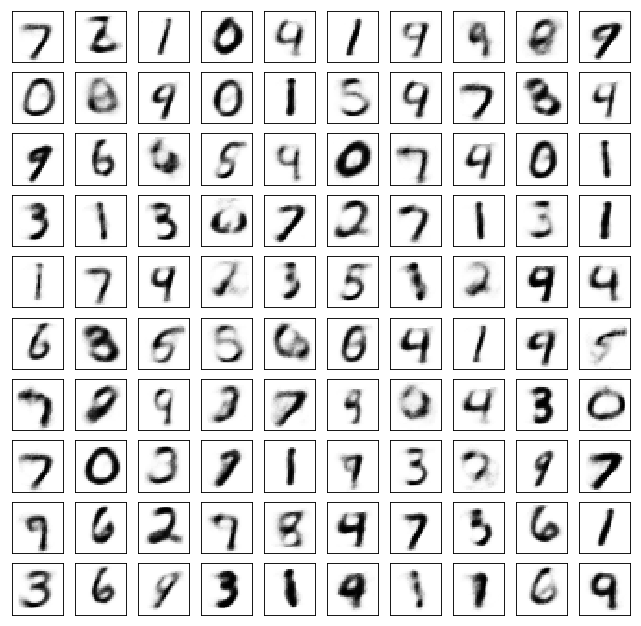

Test losses. E: 0.7240, AE: 0.1008, D: 0.6770
Train Epoch: 36 [0/50000 (0%)]	Losses E: 0.7290, AE: 0.1007, D: 0.6756
Train Epoch: 36 [25000/50000 (50%)]	Losses E: 0.7015, AE: 0.1043, D: 0.7056
Train Epoch: 36 [50000/50000 (100%)]	Losses E: 0.6931, AE: 0.1008, D: 0.6931


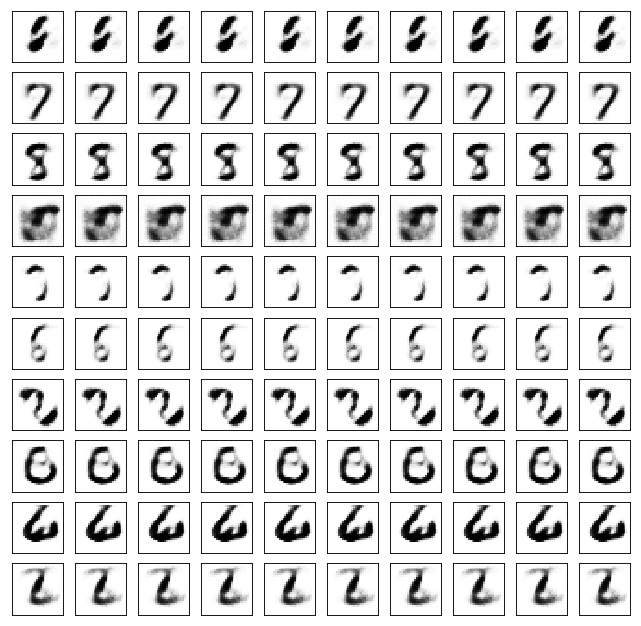

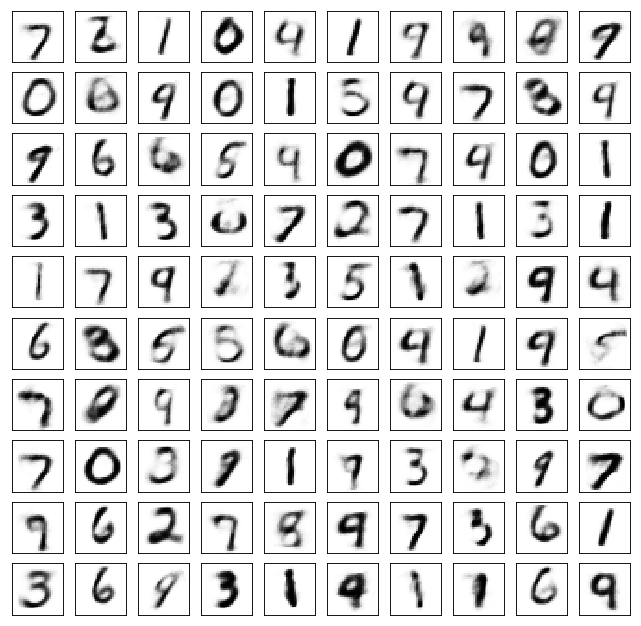

Test losses. E: 0.6921, AE: 0.1019, D: 0.6935
Train Epoch: 37 [0/50000 (0%)]	Losses E: 0.6957, AE: 0.0996, D: 0.6927
Train Epoch: 37 [25000/50000 (50%)]	Losses E: 0.7408, AE: 0.1073, D: 0.6876
Train Epoch: 37 [50000/50000 (100%)]	Losses E: 0.6698, AE: 0.1009, D: 0.6765


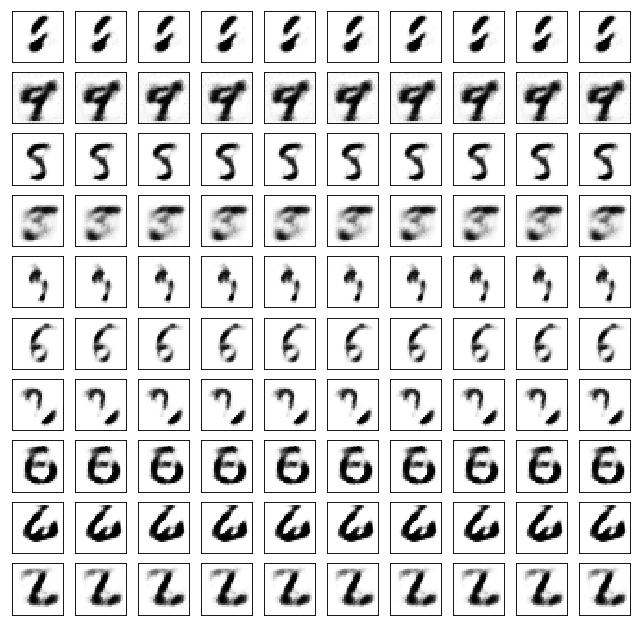

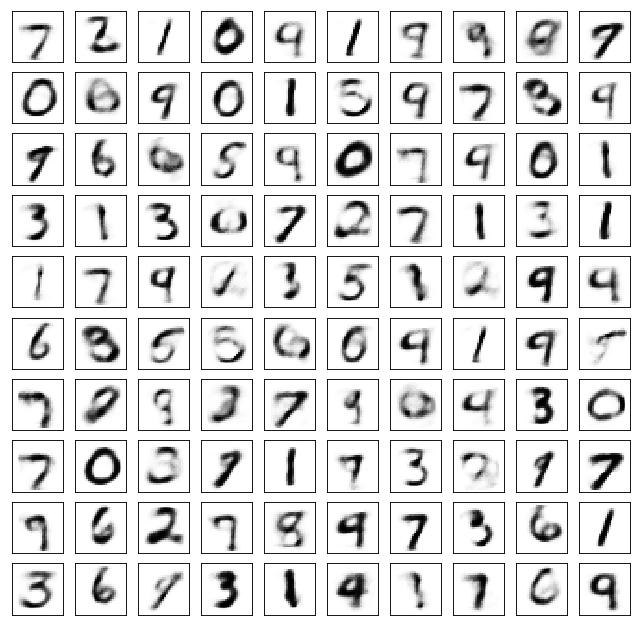

Test losses. E: 0.6624, AE: 0.1067, D: 0.6789
Train Epoch: 38 [0/50000 (0%)]	Losses E: 0.6690, AE: 0.1007, D: 0.6762
Train Epoch: 38 [25000/50000 (50%)]	Losses E: 0.6789, AE: 0.1092, D: 0.6920
Train Epoch: 38 [50000/50000 (100%)]	Losses E: 0.7171, AE: 0.1057, D: 0.6957


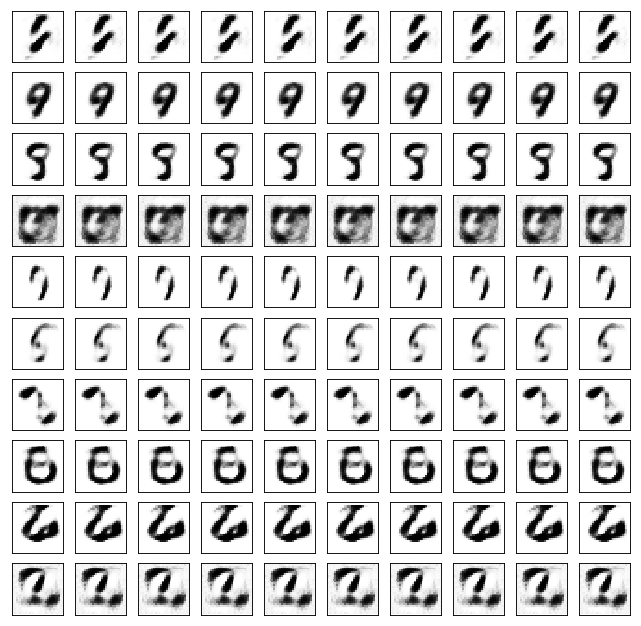

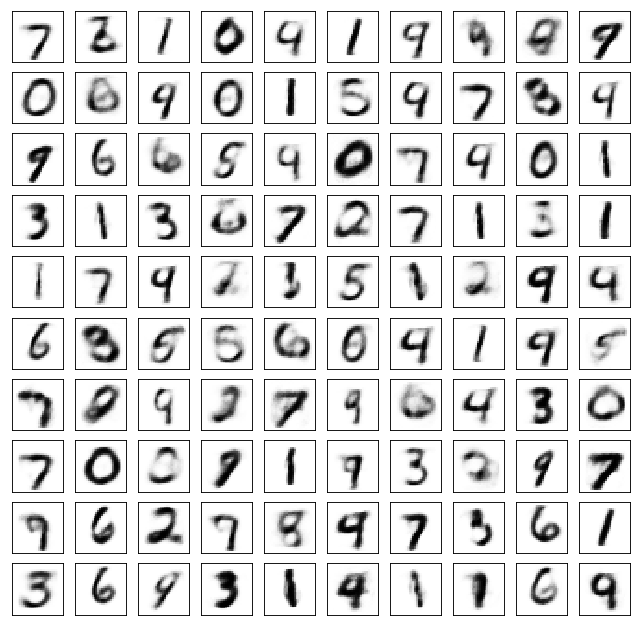

Test losses. E: 0.7119, AE: 0.1032, D: 0.6975
Train Epoch: 39 [0/50000 (0%)]	Losses E: 0.7106, AE: 0.0964, D: 0.6988
Train Epoch: 39 [25000/50000 (50%)]	Losses E: 0.6475, AE: 0.1012, D: 0.7081
Train Epoch: 39 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0941, D: 0.6980


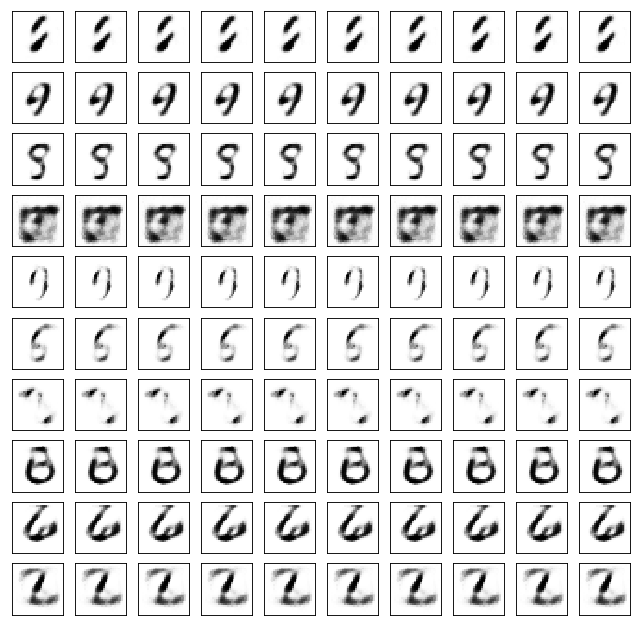

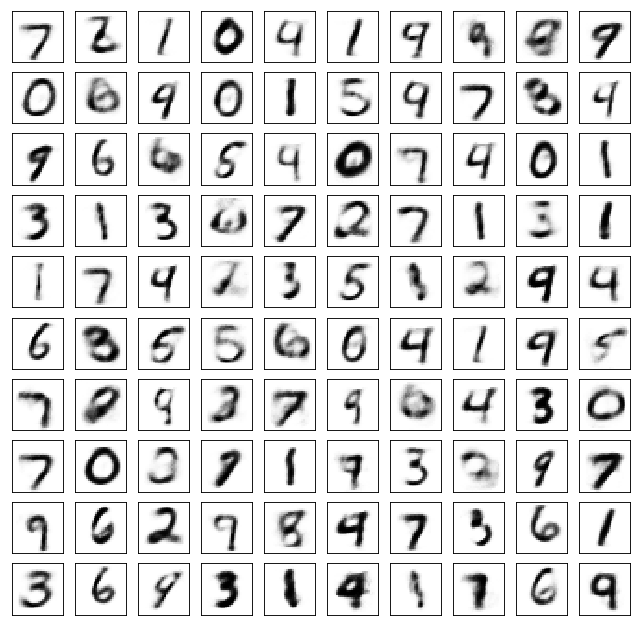

Test losses. E: 0.6910, AE: 0.0957, D: 0.6978
Train Epoch: 40 [0/50000 (0%)]	Losses E: 0.6940, AE: 0.0934, D: 0.6973
Train Epoch: 40 [25000/50000 (50%)]	Losses E: 0.6773, AE: 0.0978, D: 0.6965
Train Epoch: 40 [50000/50000 (100%)]	Losses E: 0.7297, AE: 0.1131, D: 0.7175


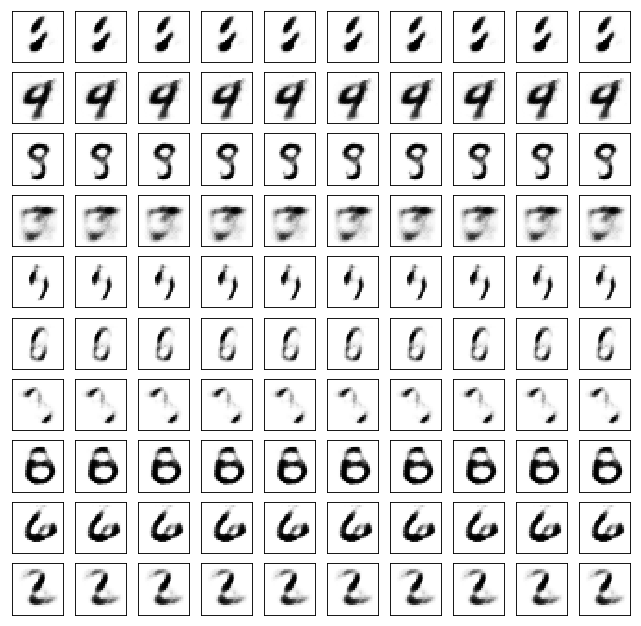

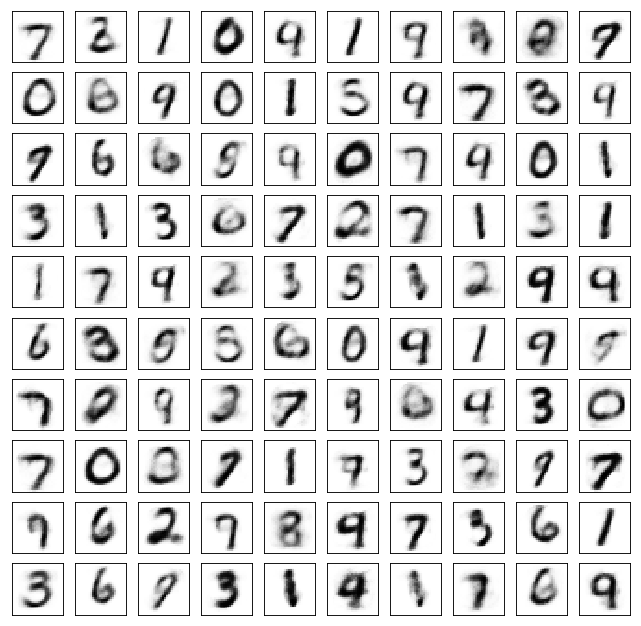

Test losses. E: 0.7300, AE: 0.1075, D: 0.7152
Train Epoch: 41 [0/50000 (0%)]	Losses E: 0.7293, AE: 0.1123, D: 0.7174
Train Epoch: 41 [25000/50000 (50%)]	Losses E: 0.7411, AE: 0.0974, D: 0.6925
Train Epoch: 41 [50000/50000 (100%)]	Losses E: 0.7176, AE: 0.1201, D: 0.7137


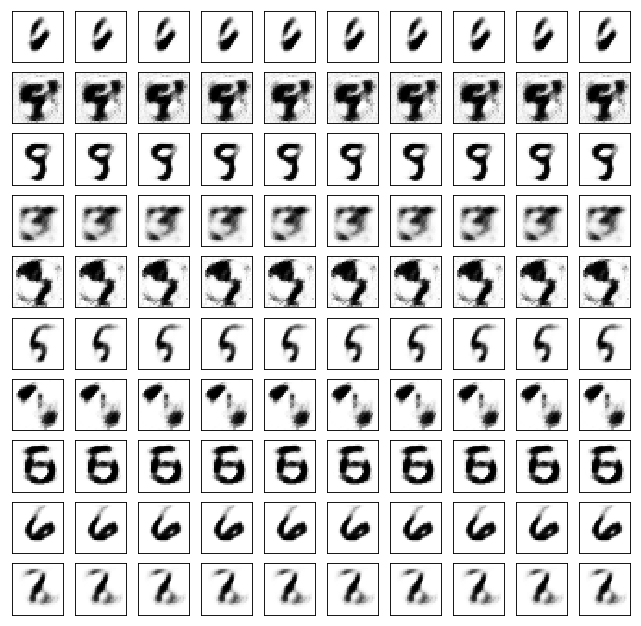

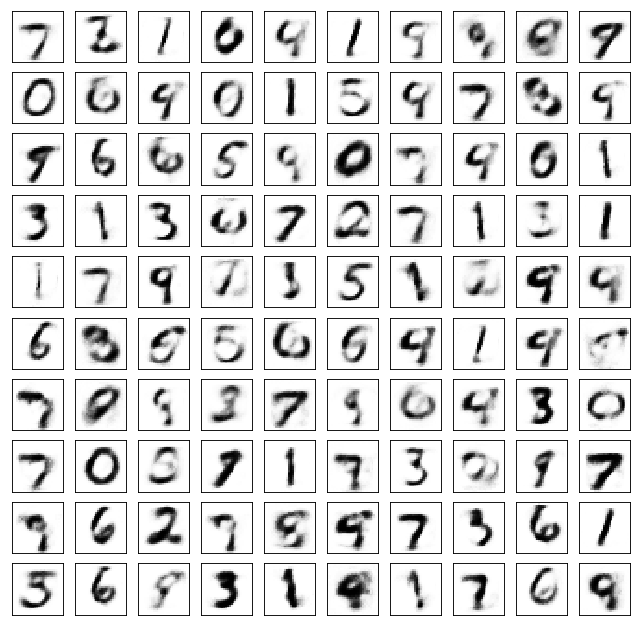

Test losses. E: 0.6990, AE: 0.1243, D: 0.7212
Train Epoch: 42 [0/50000 (0%)]	Losses E: 0.7119, AE: 0.1241, D: 0.7145
Train Epoch: 42 [25000/50000 (50%)]	Losses E: 0.7055, AE: 0.1118, D: 0.7000
Train Epoch: 42 [50000/50000 (100%)]	Losses E: 0.6885, AE: 0.0964, D: 0.7034


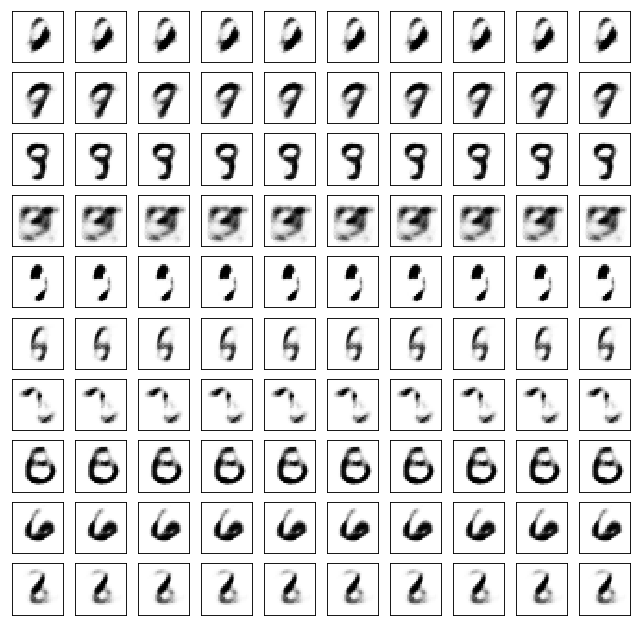

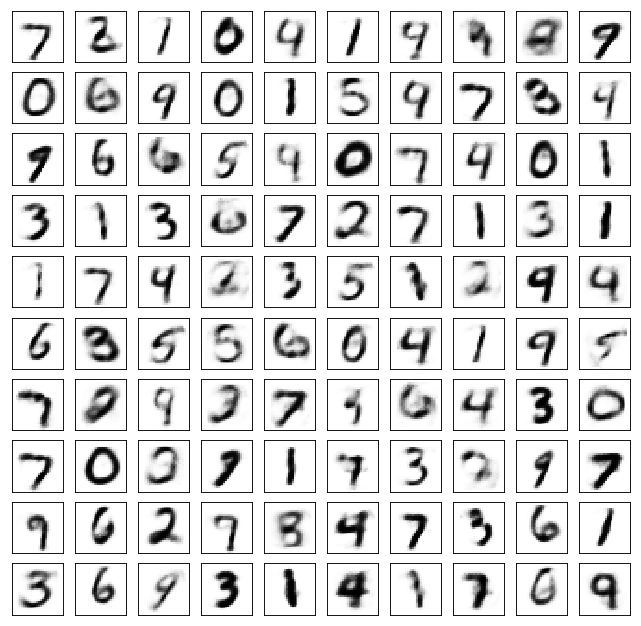

Test losses. E: 0.6855, AE: 0.0990, D: 0.7045
Train Epoch: 43 [0/50000 (0%)]	Losses E: 0.6836, AE: 0.1016, D: 0.7031
Train Epoch: 43 [25000/50000 (50%)]	Losses E: 0.7309, AE: 0.1038, D: 0.7045
Train Epoch: 43 [50000/50000 (100%)]	Losses E: 0.8192, AE: 0.1261, D: 0.7253


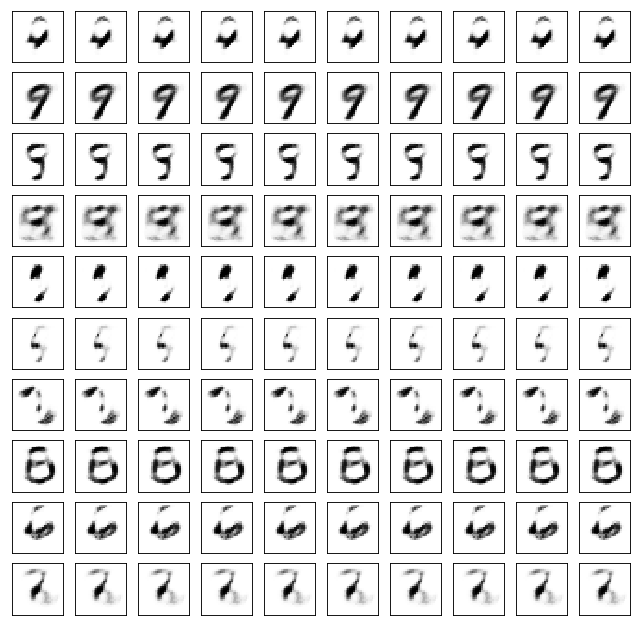

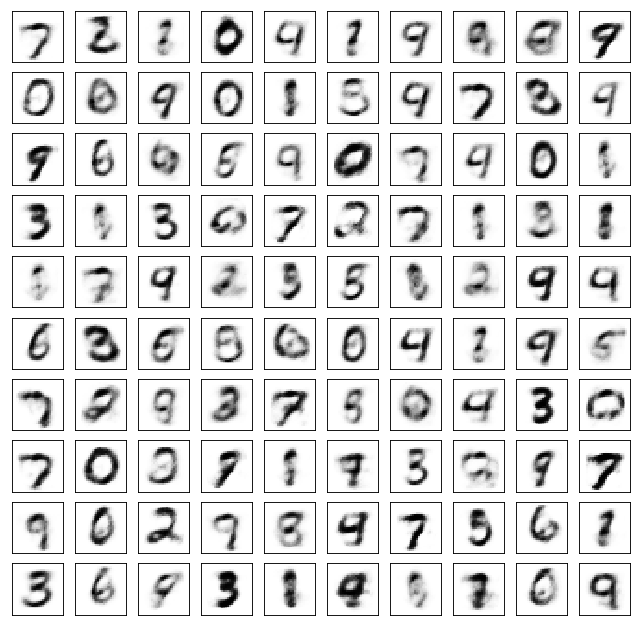

Test losses. E: 0.8051, AE: 0.1225, D: 0.7284
Train Epoch: 44 [0/50000 (0%)]	Losses E: 0.8074, AE: 0.1212, D: 0.7260
Train Epoch: 44 [25000/50000 (50%)]	Losses E: 0.6581, AE: 0.1164, D: 0.7249
Train Epoch: 44 [50000/50000 (100%)]	Losses E: 0.6881, AE: 0.1112, D: 0.7131


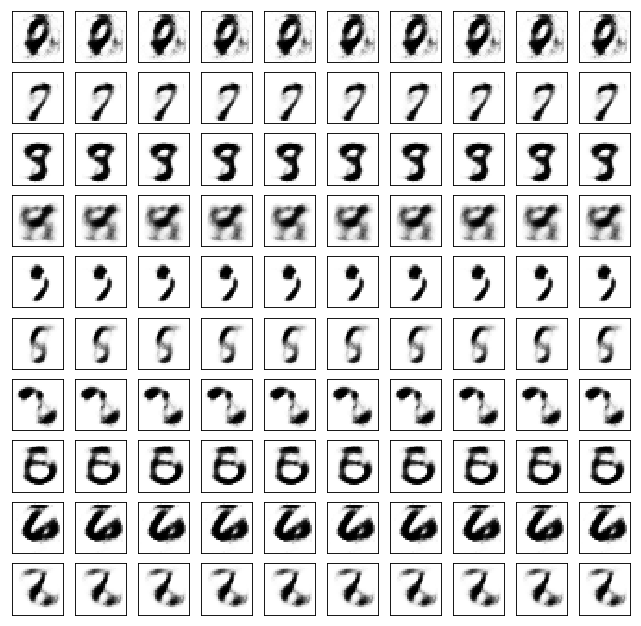

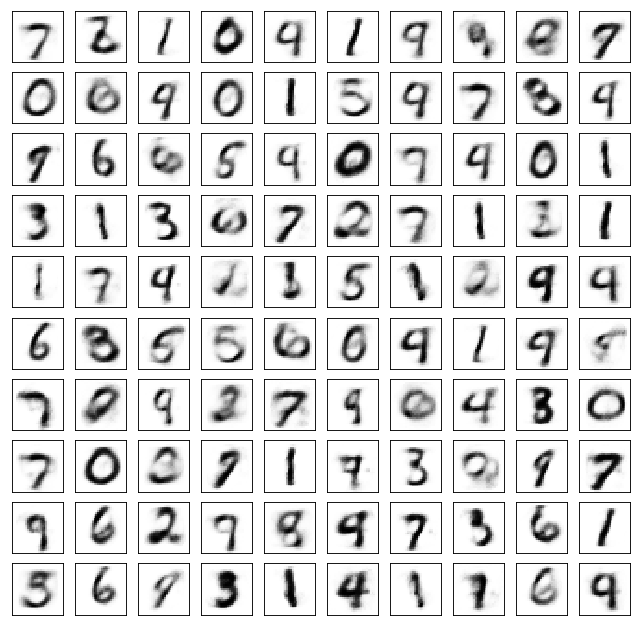

Test losses. E: 0.6873, AE: 0.1072, D: 0.7152
Train Epoch: 45 [0/50000 (0%)]	Losses E: 0.6847, AE: 0.1077, D: 0.7177
Train Epoch: 45 [25000/50000 (50%)]	Losses E: 0.7076, AE: 0.1011, D: 0.7023
Train Epoch: 45 [50000/50000 (100%)]	Losses E: 0.6623, AE: 0.0936, D: 0.7042


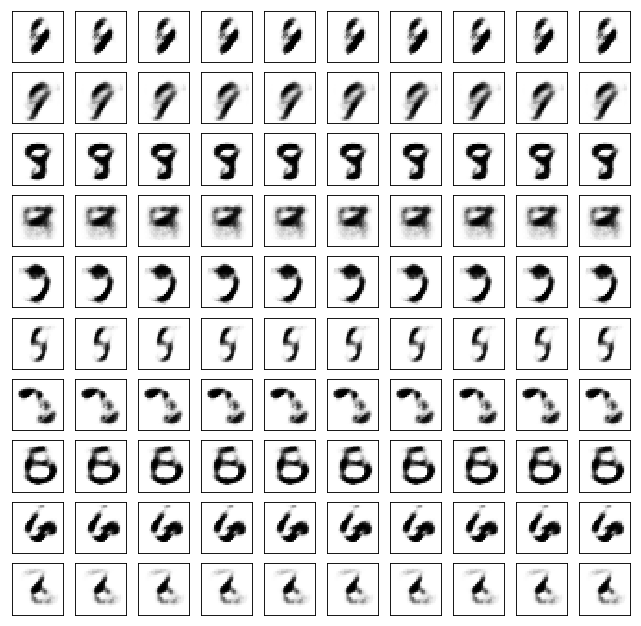

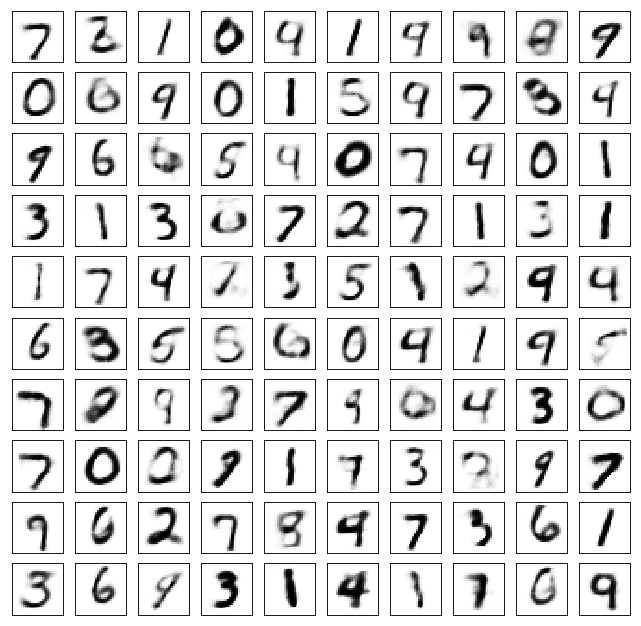

Test losses. E: 0.6594, AE: 0.0973, D: 0.7035
Train Epoch: 46 [0/50000 (0%)]	Losses E: 0.6637, AE: 0.0991, D: 0.7047
Train Epoch: 46 [25000/50000 (50%)]	Losses E: 0.6467, AE: 0.0976, D: 0.6983
Train Epoch: 46 [50000/50000 (100%)]	Losses E: 0.7226, AE: 0.0988, D: 0.7015


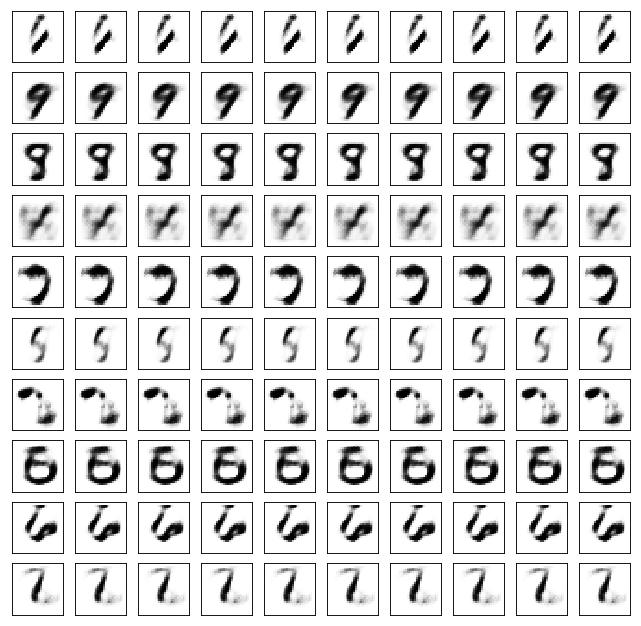

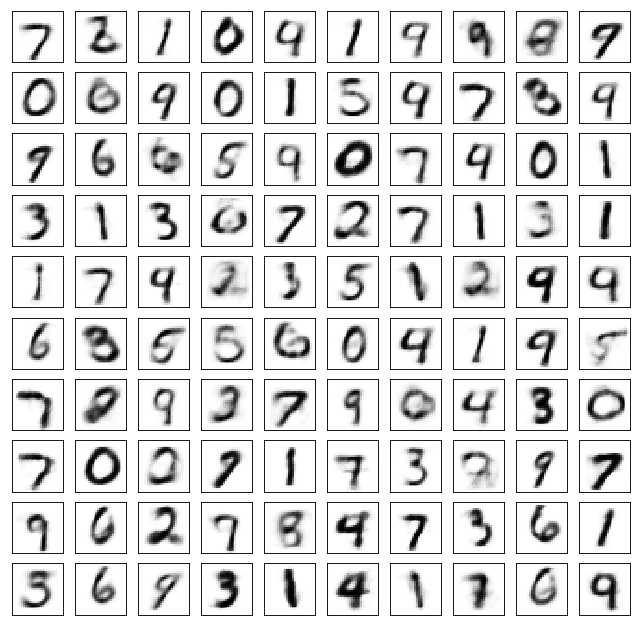

Test losses. E: 0.7212, AE: 0.0972, D: 0.7020
Train Epoch: 47 [0/50000 (0%)]	Losses E: 0.7190, AE: 0.0978, D: 0.6997
Train Epoch: 47 [25000/50000 (50%)]	Losses E: 0.7145, AE: 0.1028, D: 0.7218
Train Epoch: 47 [50000/50000 (100%)]	Losses E: 0.8548, AE: 0.1077, D: 0.6889


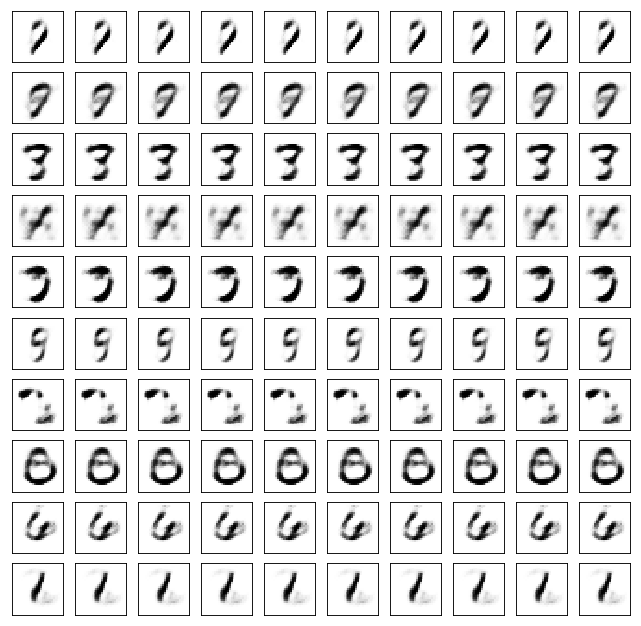

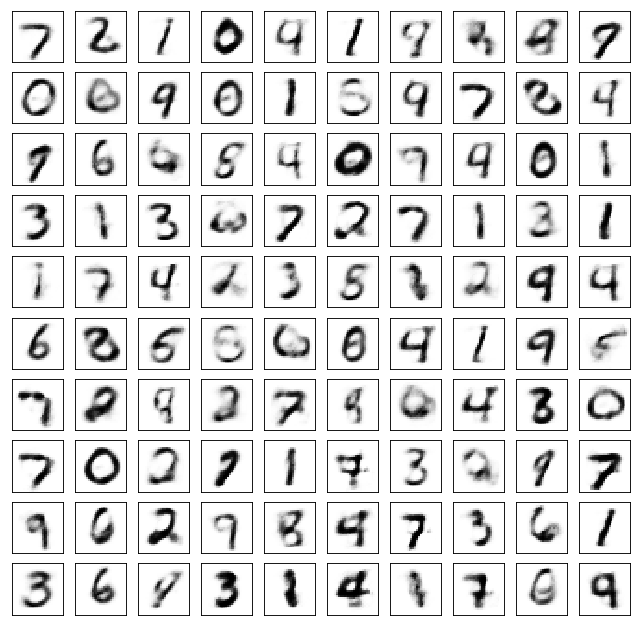

Test losses. E: 0.8384, AE: 0.1093, D: 0.6943
Train Epoch: 48 [0/50000 (0%)]	Losses E: 0.8406, AE: 0.1075, D: 0.6960
Train Epoch: 48 [25000/50000 (50%)]	Losses E: 0.6636, AE: 0.1016, D: 0.6990
Train Epoch: 48 [50000/50000 (100%)]	Losses E: 0.6520, AE: 0.1109, D: 0.7264


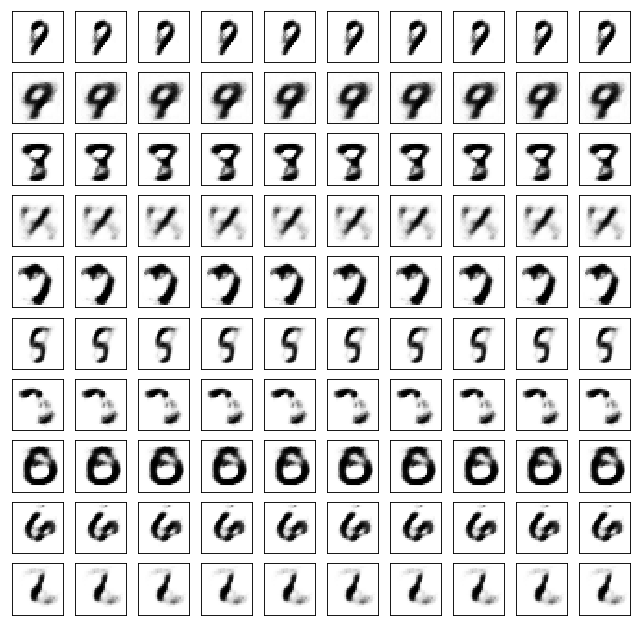

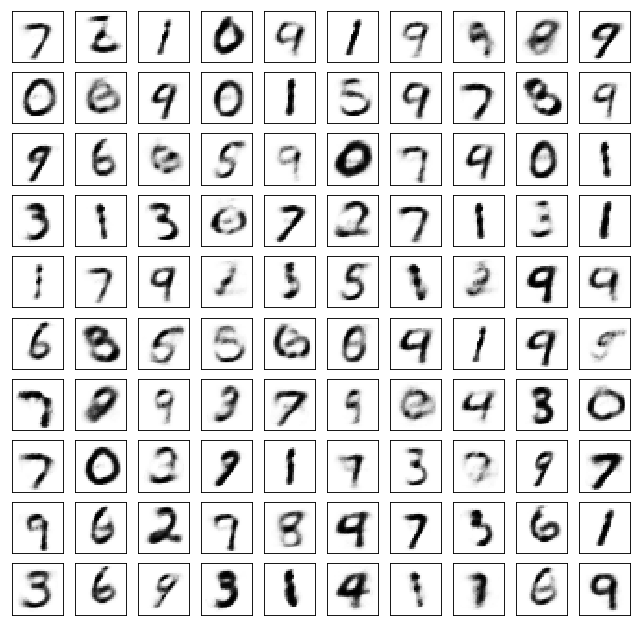

Test losses. E: 0.6489, AE: 0.1075, D: 0.7242
Train Epoch: 49 [0/50000 (0%)]	Losses E: 0.6558, AE: 0.1096, D: 0.7241
Train Epoch: 49 [25000/50000 (50%)]	Losses E: 0.6613, AE: 0.0992, D: 0.7003
Train Epoch: 49 [50000/50000 (100%)]	Losses E: 0.6789, AE: 0.0870, D: 0.6954


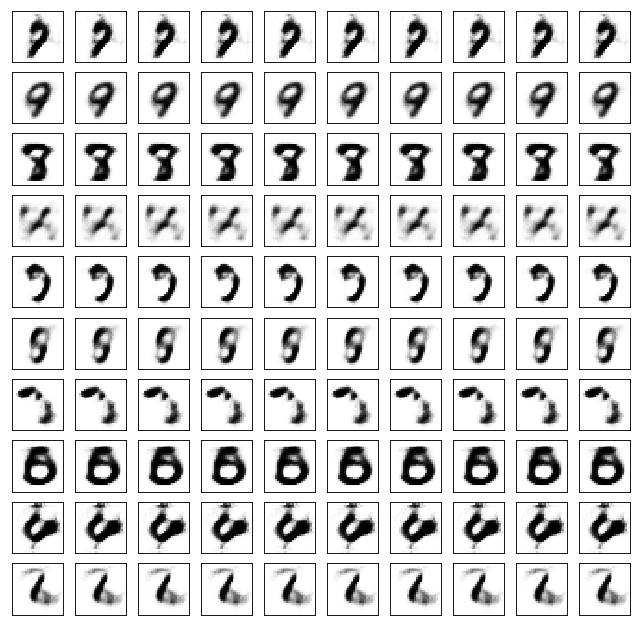

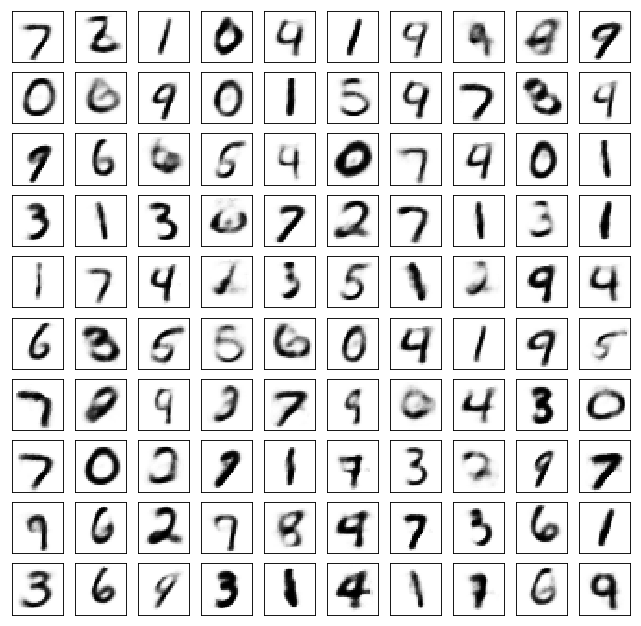

Test losses. E: 0.6774, AE: 0.0923, D: 0.6948
Train Epoch: 50 [0/50000 (0%)]	Losses E: 0.6768, AE: 0.0850, D: 0.6965
Train Epoch: 50 [25000/50000 (50%)]	Losses E: 0.7214, AE: 0.0962, D: 0.7028
Train Epoch: 50 [50000/50000 (100%)]	Losses E: 0.7388, AE: 0.0916, D: 0.6998


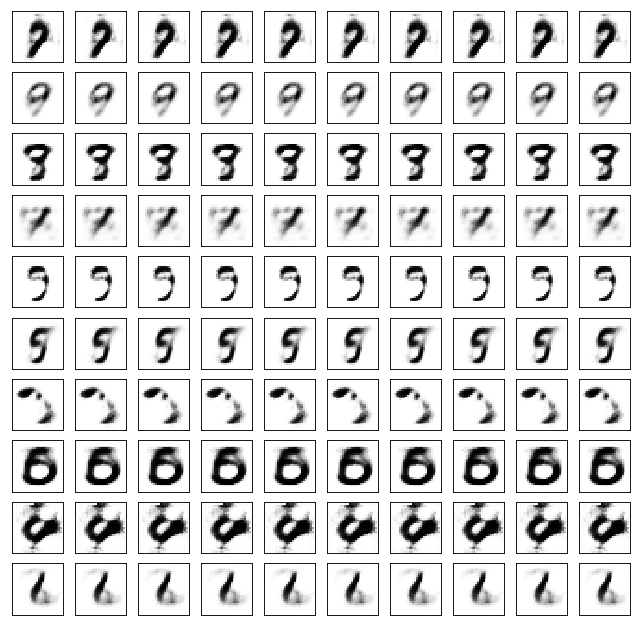

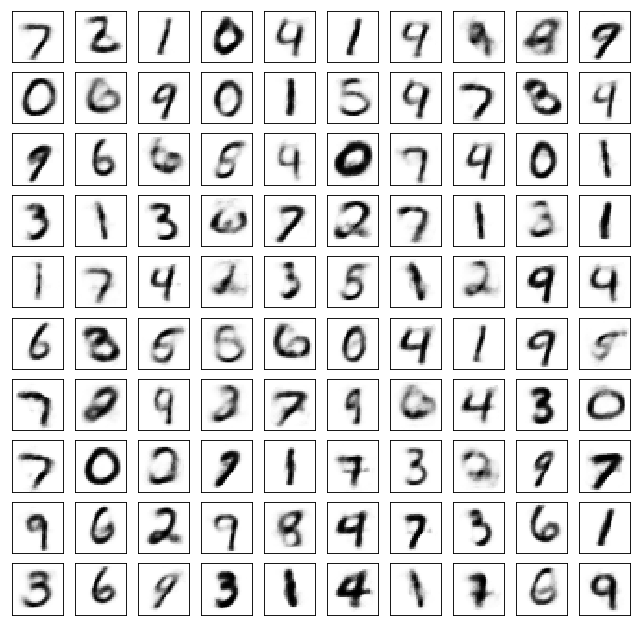

Test losses. E: 0.7385, AE: 0.0923, D: 0.6984
Train Epoch: 51 [0/50000 (0%)]	Losses E: 0.7401, AE: 0.0897, D: 0.6966
Train Epoch: 51 [25000/50000 (50%)]	Losses E: 0.6999, AE: 0.0882, D: 0.6973
Train Epoch: 51 [50000/50000 (100%)]	Losses E: 0.6939, AE: 0.0923, D: 0.6950


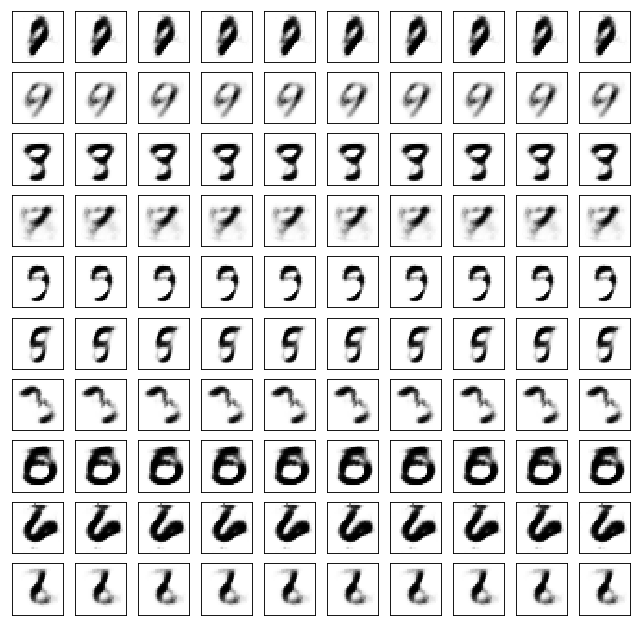

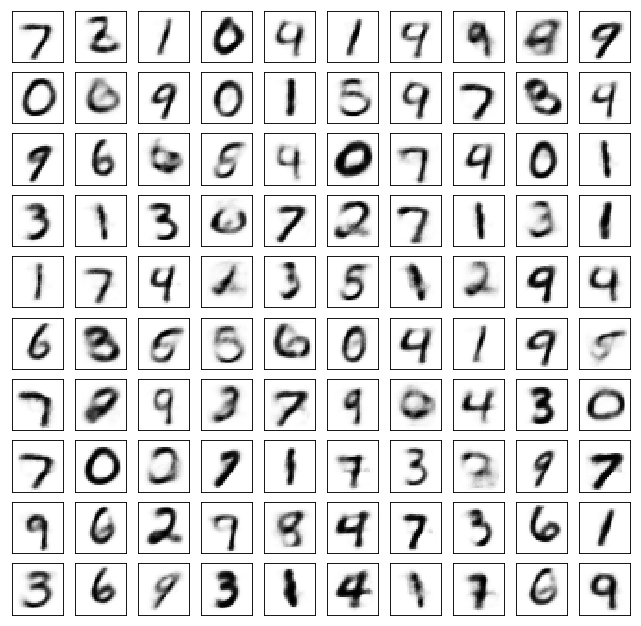

Test losses. E: 0.6938, AE: 0.0916, D: 0.6930
Train Epoch: 52 [0/50000 (0%)]	Losses E: 0.6929, AE: 0.0937, D: 0.6924
Train Epoch: 52 [25000/50000 (50%)]	Losses E: 0.6609, AE: 0.0887, D: 0.7010
Train Epoch: 52 [50000/50000 (100%)]	Losses E: 0.6352, AE: 0.0894, D: 0.7098


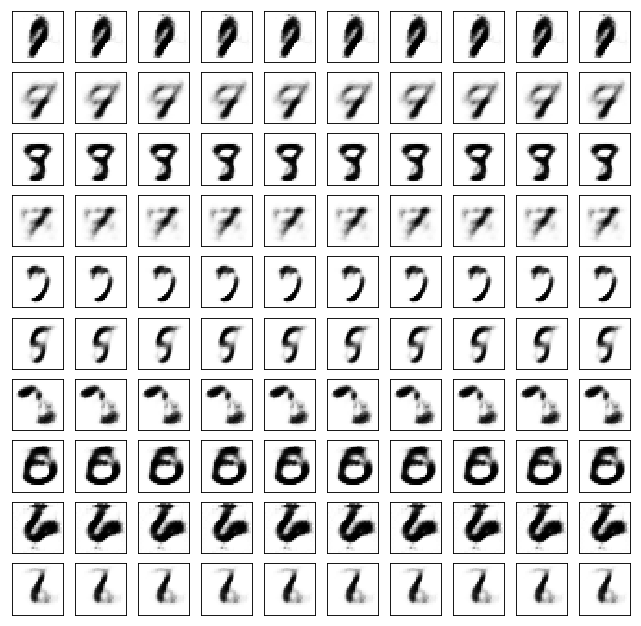

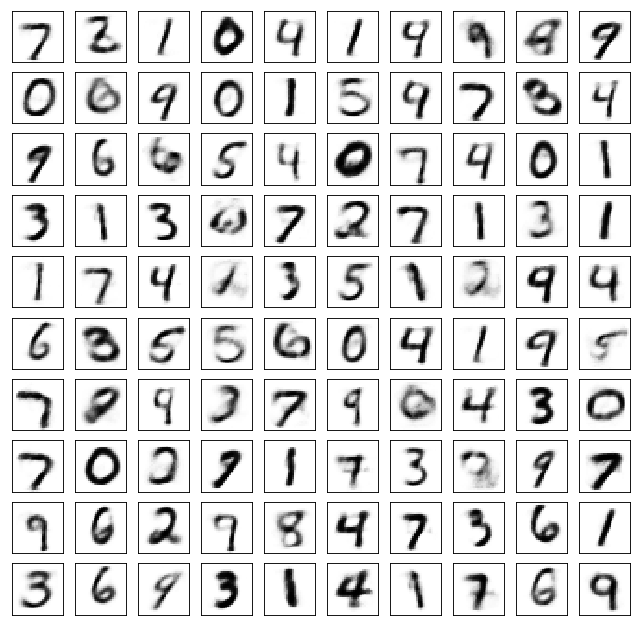

Test losses. E: 0.6319, AE: 0.0913, D: 0.7119
Train Epoch: 53 [0/50000 (0%)]	Losses E: 0.6323, AE: 0.0880, D: 0.7162
Train Epoch: 53 [25000/50000 (50%)]	Losses E: 0.6427, AE: 0.0899, D: 0.7112
Train Epoch: 53 [50000/50000 (100%)]	Losses E: 0.6850, AE: 0.0894, D: 0.6916


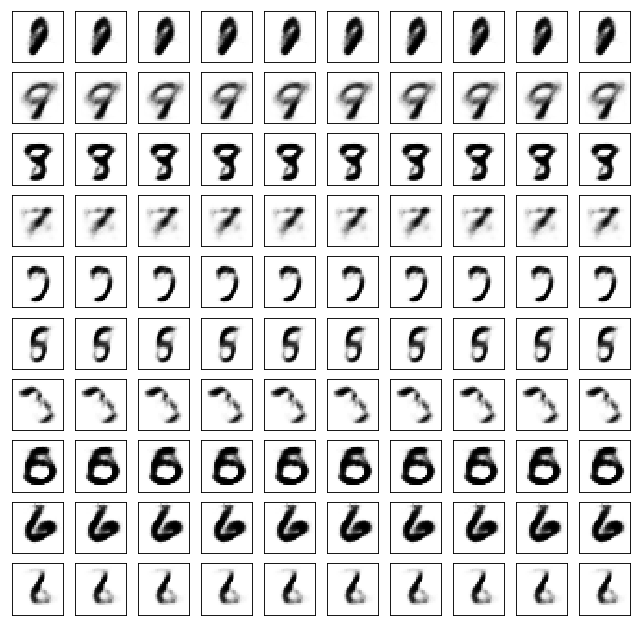

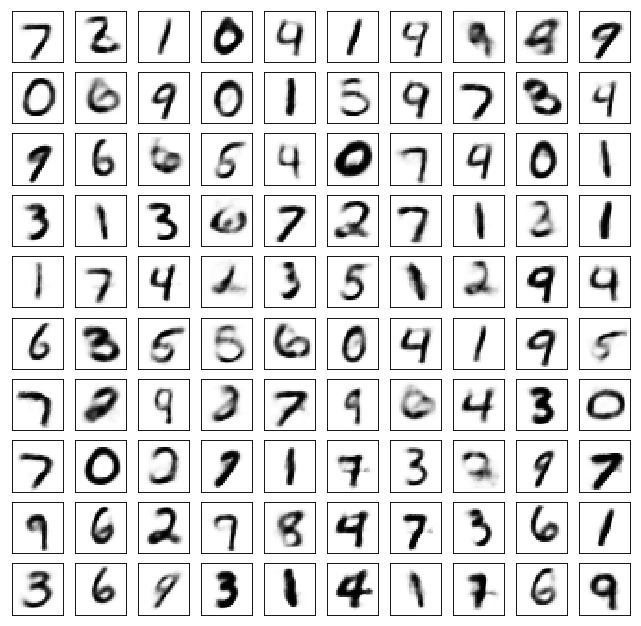

Test losses. E: 0.6863, AE: 0.0888, D: 0.6904
Train Epoch: 54 [0/50000 (0%)]	Losses E: 0.6863, AE: 0.0915, D: 0.6922
Train Epoch: 54 [25000/50000 (50%)]	Losses E: 0.7187, AE: 0.1024, D: 0.6961
Train Epoch: 54 [50000/50000 (100%)]	Losses E: 0.6889, AE: 0.0823, D: 0.6925


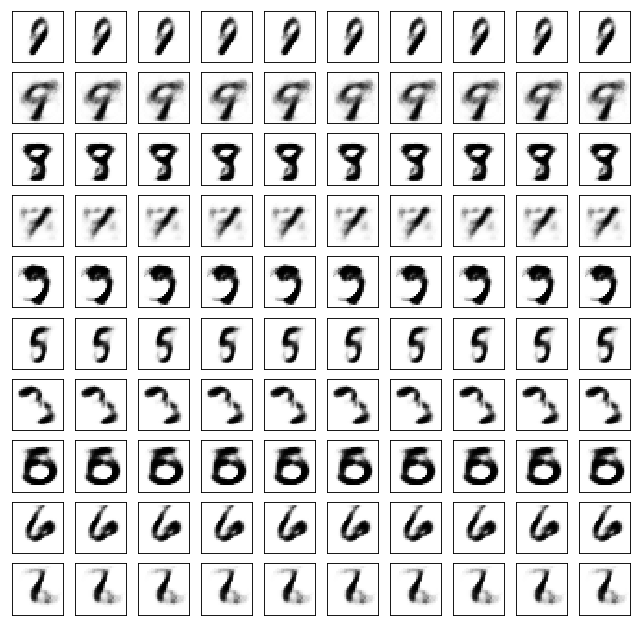

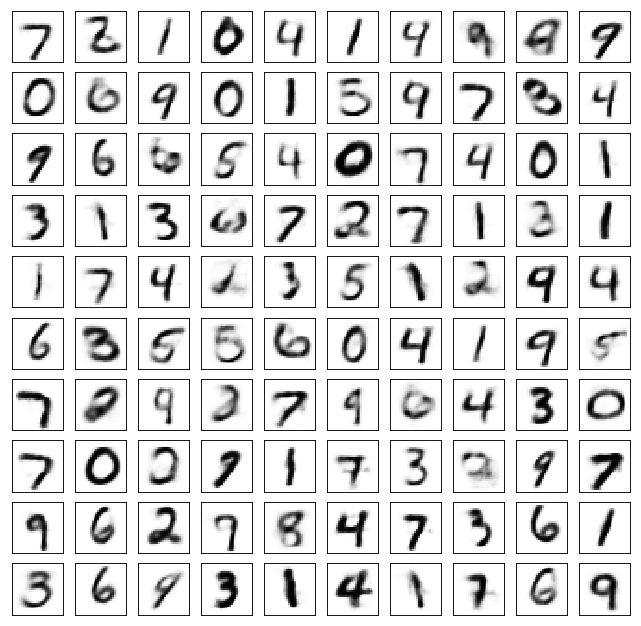

Test losses. E: 0.6879, AE: 0.0865, D: 0.6918
Train Epoch: 55 [0/50000 (0%)]	Losses E: 0.6857, AE: 0.0834, D: 0.6931
Train Epoch: 55 [25000/50000 (50%)]	Losses E: 0.6462, AE: 0.0831, D: 0.6985
Train Epoch: 55 [50000/50000 (100%)]	Losses E: 0.7169, AE: 0.0885, D: 0.6955


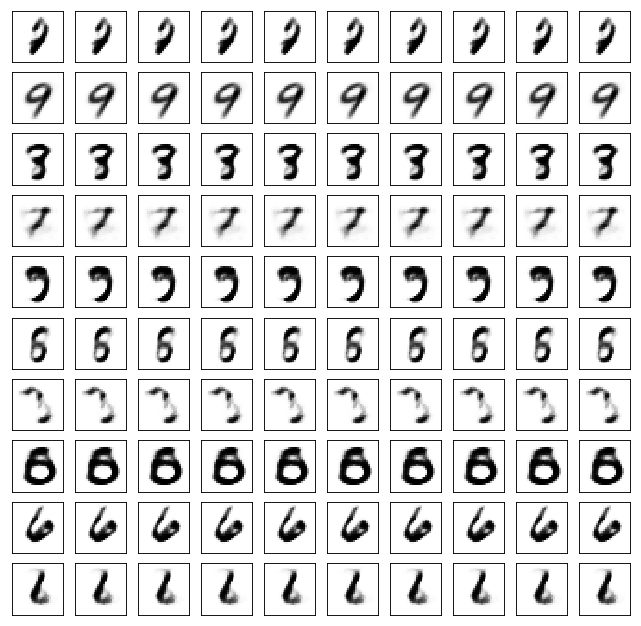

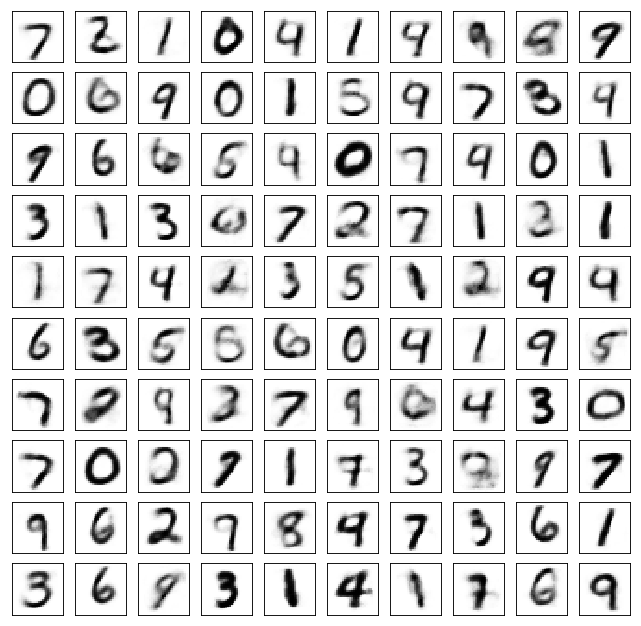

Test losses. E: 0.7155, AE: 0.0882, D: 0.6948
Train Epoch: 56 [0/50000 (0%)]	Losses E: 0.7187, AE: 0.0866, D: 0.6947
Train Epoch: 56 [25000/50000 (50%)]	Losses E: 0.7279, AE: 0.0815, D: 0.6952
Train Epoch: 56 [50000/50000 (100%)]	Losses E: 0.6706, AE: 0.0959, D: 0.7063


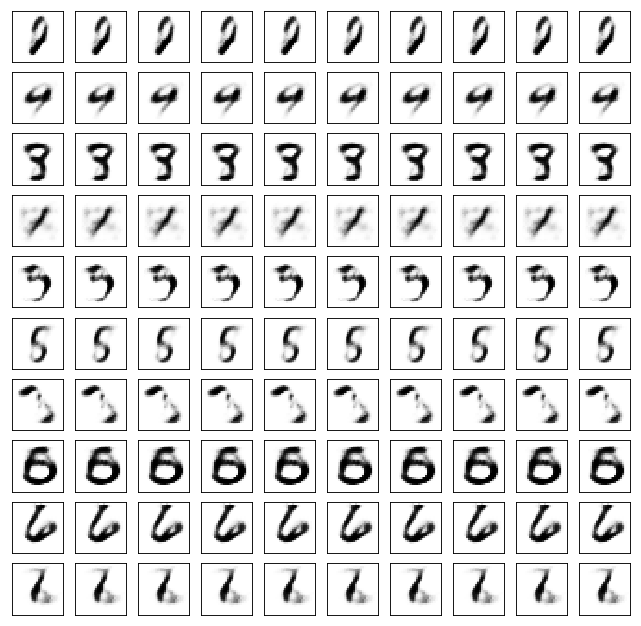

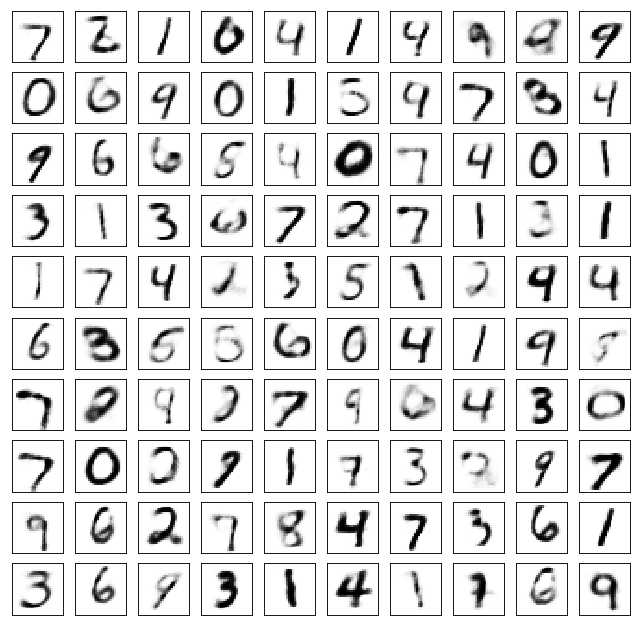

Test losses. E: 0.6608, AE: 0.0977, D: 0.7096
Train Epoch: 57 [0/50000 (0%)]	Losses E: 0.6695, AE: 0.0942, D: 0.7085
Train Epoch: 57 [25000/50000 (50%)]	Losses E: 0.7845, AE: 0.1004, D: 0.6984
Train Epoch: 57 [50000/50000 (100%)]	Losses E: 0.7202, AE: 0.1030, D: 0.7114


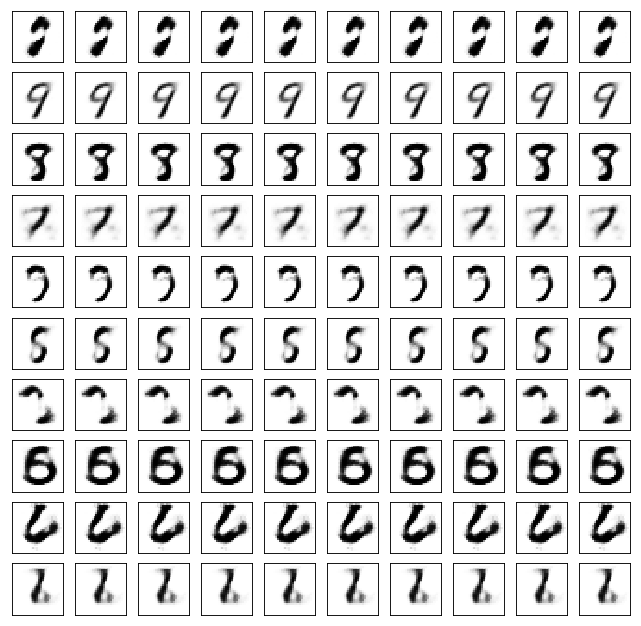

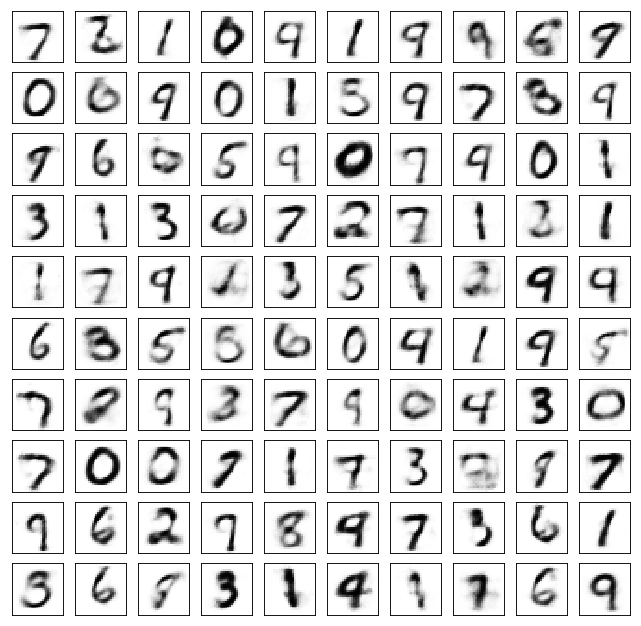

Test losses. E: 0.7185, AE: 0.1033, D: 0.7081
Train Epoch: 58 [0/50000 (0%)]	Losses E: 0.7184, AE: 0.1017, D: 0.7103
Train Epoch: 58 [25000/50000 (50%)]	Losses E: 0.7182, AE: 0.1064, D: 0.6987
Train Epoch: 58 [50000/50000 (100%)]	Losses E: 0.7360, AE: 0.0936, D: 0.7025


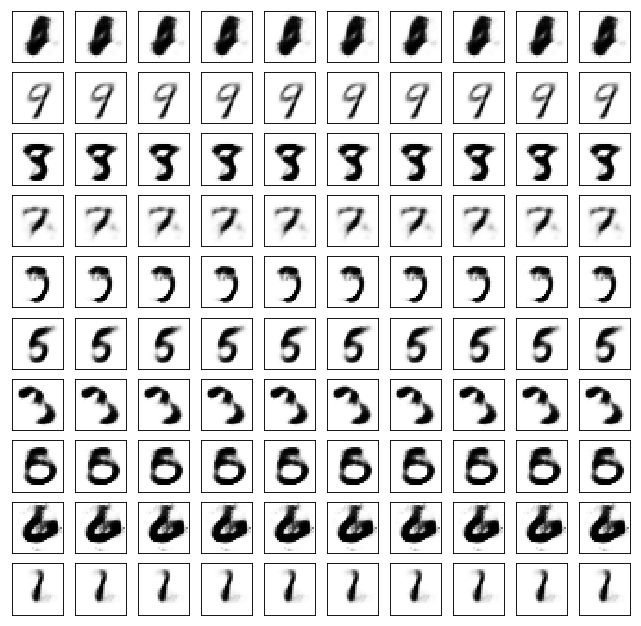

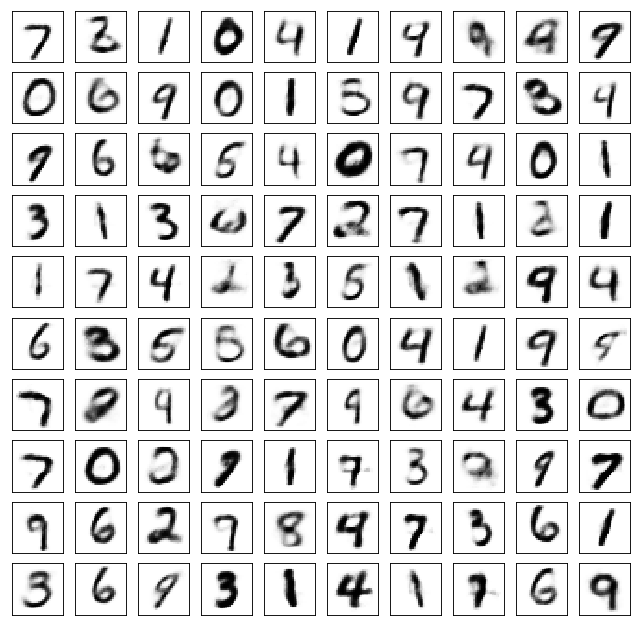

Test losses. E: 0.7282, AE: 0.0923, D: 0.7047
Train Epoch: 59 [0/50000 (0%)]	Losses E: 0.7275, AE: 0.0916, D: 0.7083
Train Epoch: 59 [25000/50000 (50%)]	Losses E: 0.7087, AE: 0.0944, D: 0.6965
Train Epoch: 59 [50000/50000 (100%)]	Losses E: 0.7047, AE: 0.0866, D: 0.6941


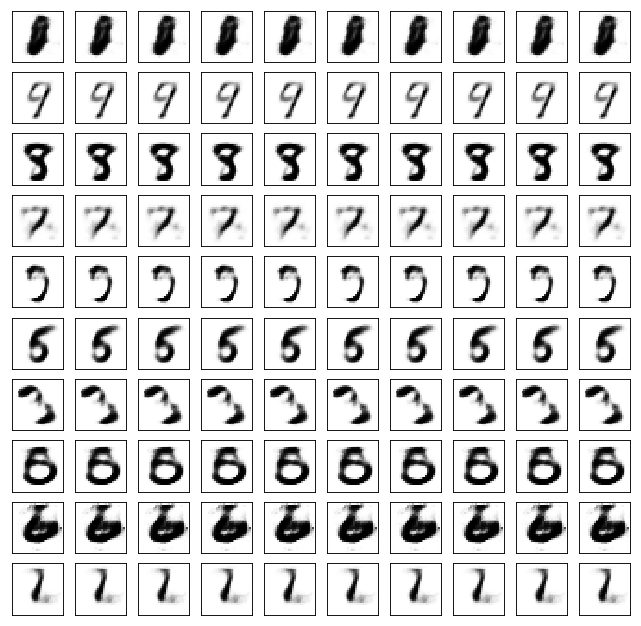

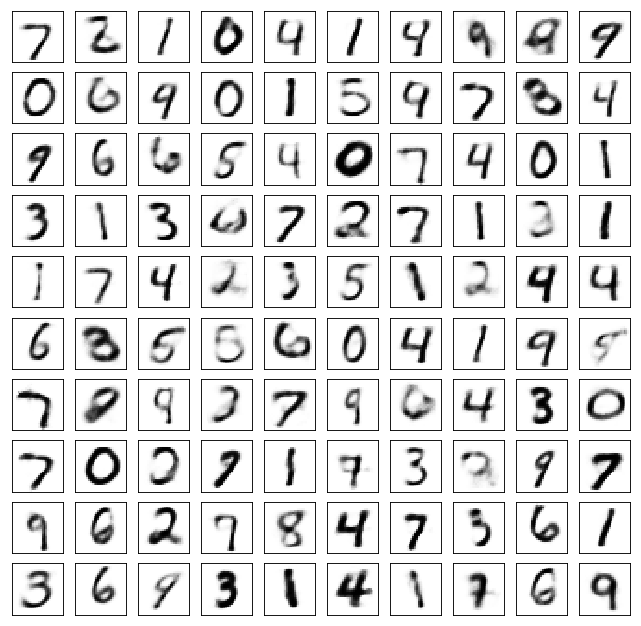

Test losses. E: 0.7035, AE: 0.0886, D: 0.6952
Train Epoch: 60 [0/50000 (0%)]	Losses E: 0.7039, AE: 0.0896, D: 0.6945
Train Epoch: 60 [25000/50000 (50%)]	Losses E: 0.6946, AE: 0.0882, D: 0.6989
Train Epoch: 60 [50000/50000 (100%)]	Losses E: 0.6457, AE: 0.0864, D: 0.7029


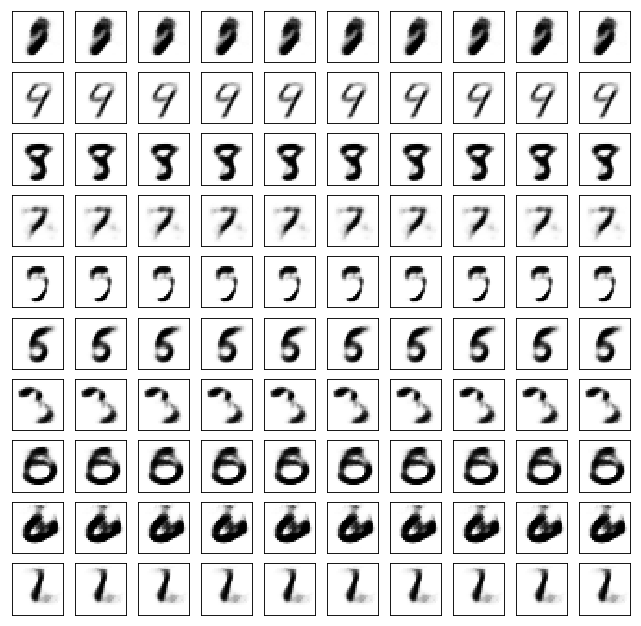

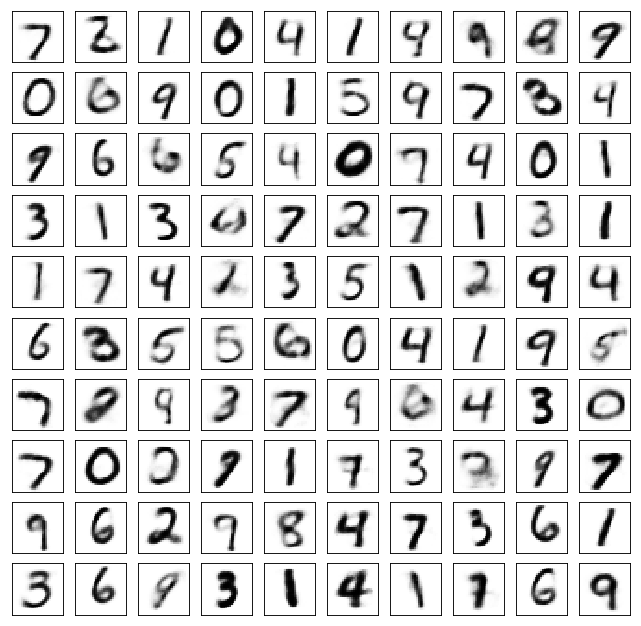

Test losses. E: 0.6433, AE: 0.0841, D: 0.7021
Train Epoch: 61 [0/50000 (0%)]	Losses E: 0.6433, AE: 0.0784, D: 0.7022
Train Epoch: 61 [25000/50000 (50%)]	Losses E: 0.6545, AE: 0.0821, D: 0.7002
Train Epoch: 61 [50000/50000 (100%)]	Losses E: 0.6417, AE: 0.0895, D: 0.6874


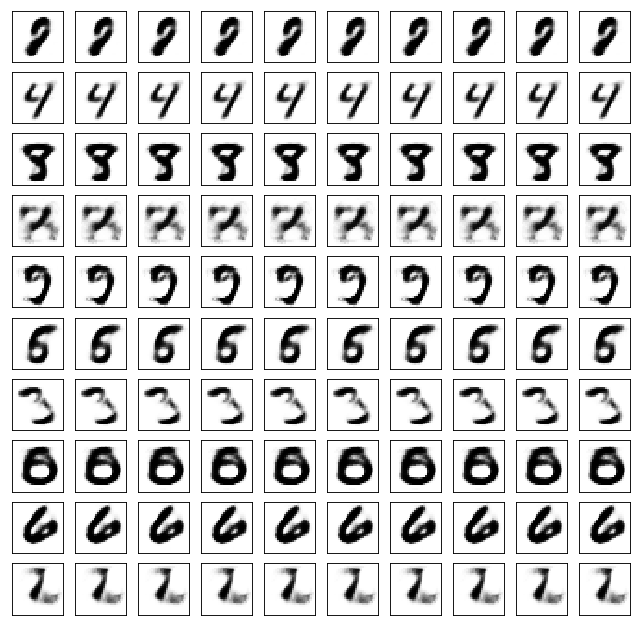

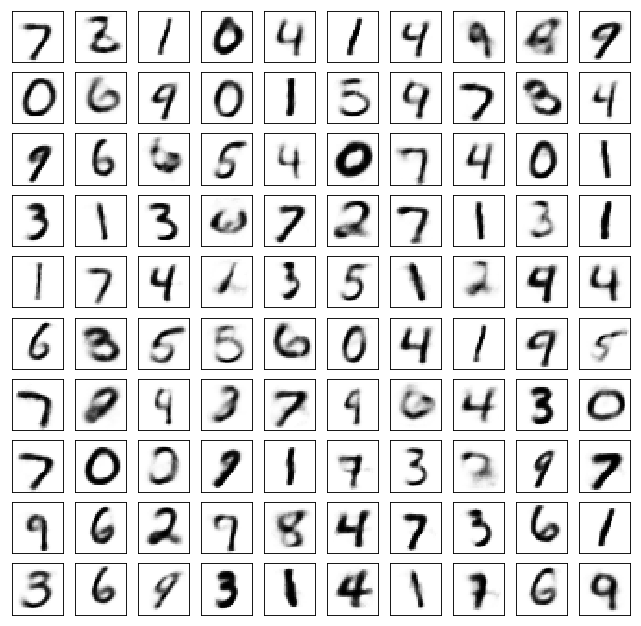

Test losses. E: 0.6407, AE: 0.0861, D: 0.6859
Train Epoch: 62 [0/50000 (0%)]	Losses E: 0.6391, AE: 0.0912, D: 0.6868
Train Epoch: 62 [25000/50000 (50%)]	Losses E: 0.6566, AE: 0.0902, D: 0.7030
Train Epoch: 62 [50000/50000 (100%)]	Losses E: 0.7003, AE: 0.0811, D: 0.6891


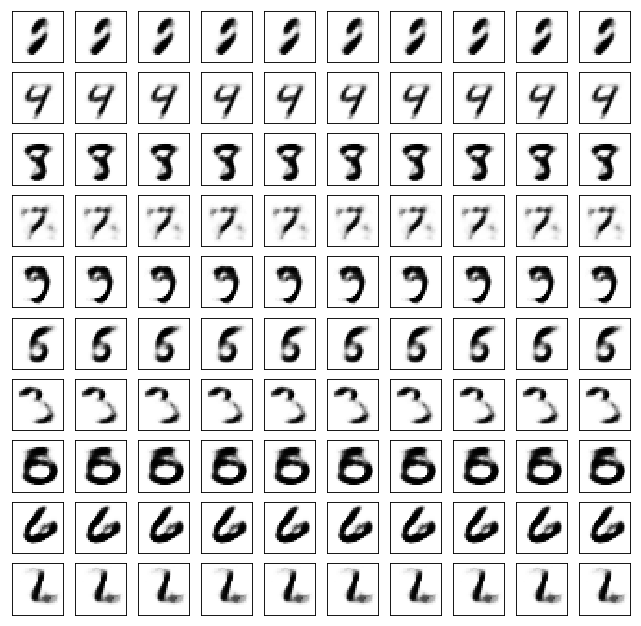

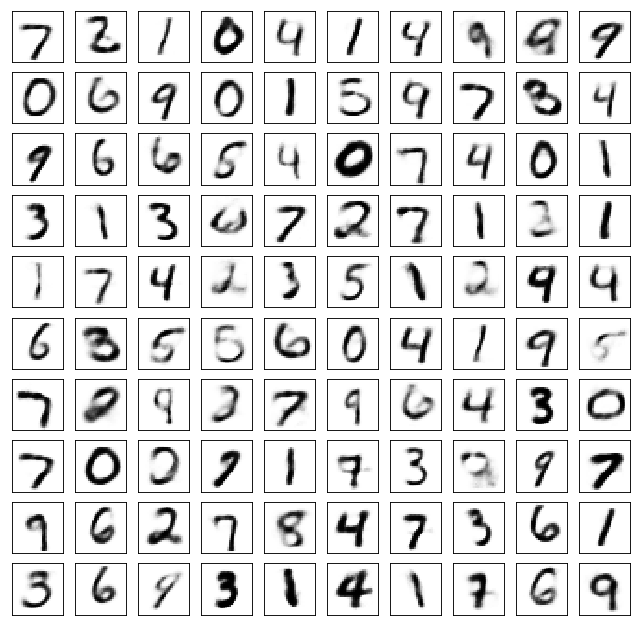

Test losses. E: 0.6960, AE: 0.0843, D: 0.6911
Train Epoch: 63 [0/50000 (0%)]	Losses E: 0.6963, AE: 0.0881, D: 0.6894


KeyboardInterrupt: 

In [58]:
for epoch in range(1, 1001):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)